Review of NYT Middle East Coverage:
 - Specific Data Corpus (Date, Author, Title, Article)
 - Keywords across Corpus
 - Keywords by author
 - Keywords at time periods
 - Sentiment of article (total, by organization, by person)
 - Ability to ask a question:
   - Corpus
   - Specific Author
    - Specific Article

In [11]:
## Imports
# ---- Core Utilities ----
import os
import re
import json
import warnings
from pathlib import Path

# ---- Data Handling ----
import numpy as np
import pandas as pd

# ---- Text Processing (NLTK) ----
import nltk
for pkg in ["punkt", "punkt_tab", "wordnet", "omw-1.4", "stopwords", "vader_lexicon"]:
    nltk.download(pkg, quiet=True)

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer  # if you still want TF-IDF baselines

# ---- PDF / HTML Extraction ----
from pypdf import PdfReader          # modern replacement for PyPDF2
from bs4 import BeautifulSoup        # in case you ingest HTML or scraped content

# ---- Optional: Fast Data Loading / Storage ----
import duckdb
import pyarrow as pa
import pyarrow.parquet as pq

In [12]:
## Sentiment Imports
from transformers import pipeline

# Ensure sentence tokenizer is available
os.environ["TOKENIZERS_PARALLELISM"] = "true"
nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)




True

In [13]:
## Sentiment GPU
import torch

# Use 12 threads on your i9-11900K (optimal balance of speed & responsiveness)
torch.set_num_threads(12)

MODEL_ID = "cardiffnlp/twitter-roberta-base-sentiment-latest"

clf = pipeline(
    "text-classification",
    model=MODEL_ID,
    tokenizer=MODEL_ID,
    truncation=True,
    max_length=512,   # ✅ Token-level truncation for efficiency & consistency
    device=-1,        # ✅ CPU mode (unless you have CUDA GPU)
)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
import os
os.getcwd()

'C:\\Users\\nicol\\flex\\ChatGPT\\NewsAnalysis2025'

In [15]:
## Import Key (need to have the text file in the same folder w the key)

from dotenv import load_dotenv
load_dotenv()

True

In [16]:
from openai import OpenAI
client = OpenAI()

resp = client.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[{"role":"user","content":"Hello!"}]
)

print(resp.choices[0].message.content)

Hello! How can I assist you today?


In [7]:
# Load the CSV (adjust the path if needed)
NewData_df = pd.read_csv("./Data/NYT_Data_20251105V1.csv", encoding="cp1252")

In [8]:
# Review 
NewData_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   #                     291 non-null    int64  
 1   Date                  291 non-null    int64  
 2   Author                291 non-null    object 
 3   Publication           291 non-null    object 
 4   Title                 291 non-null    object 
 5   First Paragraph       291 non-null    object 
 6   Anti-Semitic          158 non-null    float64
 7   Not Anti-Semitic      19 non-null     float64
 8   Anti-Israel           154 non-null    float64
 9   Anti-Palestinian      121 non-null    float64
 10  Not Anti-Palestinian  152 non-null    float64
 11  Anti-Hamas            152 non-null    float64
 12  Op-Ed                 281 non-null    float64
 13  Anti-Semtic Reason1   22 non-null     float64
 14  Anti-Semtic Reason2   36 non-null     float64
dtypes: float64(9), int64(2)

In [9]:
#Review 
NewData_df.shape

(291, 15)

In [10]:
# Preview first few rows
NewData_df.head()

,#,Date,Author,Publication,Title,First Paragraph,Anti-Semitic,Not Anti-Semitic,Anti-Israel,Anti-Palestinian,Not Anti-Palestinian,Anti-Hamas,Op-Ed,Anti-Semtic Reason1,Anti-Semtic Reason2
0,1,45952,Bret Stephens,The New York Times,Why Mamdani Frightens Jews Like Me,A recent Fox News poll found that 38 percent o...,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN
1,2,45944,Bret Stephens,The New York Times,Why Israel Won the War,"Though it seems absurd in retrospect, there we...",0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN
2,3,45937,Bret Stephens,The New York Times,What Israel Should Learn From Two Years of War,Maya Angelou’s classic warning should have bee...,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN
3,4,45909,Bret Stephens,The New York Times,Gesture Politics Won’t Help Palestinians,"This month, France, Canada, Australia and poss...",0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN
4,5,45874,Bret Stephens,The New York Times,Where Can Gaza Go From Here?,First and most obviously: The government of Is...,0.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN


In [11]:
# Replace NaN
NewData_df.fillna(0, inplace=True)

In [12]:
# Preview first few rows
NewData_df.head()

,#,Date,Author,Publication,Title,First Paragraph,Anti-Semitic,Not Anti-Semitic,Anti-Israel,Anti-Palestinian,Not Anti-Palestinian,Anti-Hamas,Op-Ed,Anti-Semtic Reason1,Anti-Semtic Reason2
0,1,45952,Bret Stephens,The New York Times,Why Mamdani Frightens Jews Like Me,A recent Fox News poll found that 38 percent o...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,45944,Bret Stephens,The New York Times,Why Israel Won the War,"Though it seems absurd in retrospect, there we...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,45937,Bret Stephens,The New York Times,What Israel Should Learn From Two Years of War,Maya Angelou’s classic warning should have bee...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,45909,Bret Stephens,The New York Times,Gesture Politics Won’t Help Palestinians,"This month, France, Canada, Australia and poss...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,45874,Bret Stephens,The New York Times,Where Can Gaza Go From Here?,First and most obviously: The government of Is...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
NewData_df["title_word_count"] = (
    NewData_df["Title"].fillna("").str.split().str.len()
)

NewData_df["First_Para_word_count"] = (
    NewData_df["First Paragraph"].fillna("").str.split().str.len()
)

In [14]:
NewData_df[["Title", "title_word_count", "First Paragraph", "First_Para_word_count"]].head()

,Title,title_word_count,First Paragraph,First_Para_word_count
0,Why Mamdani Frightens Jews Like Me,6,A recent Fox News poll found that 38 percent o...,55
1,Why Israel Won the War,5,"Though it seems absurd in retrospect, there we...",30
2,What Israel Should Learn From Two Years of War,9,Maya Angelou’s classic warning should have bee...,73
3,Gesture Politics Won’t Help Palestinians,5,"This month, France, Canada, Australia and poss...",61
4,Where Can Gaza Go From Here?,6,First and most obviously: The government of Is...,32


In [15]:
NewData_df.head()

,#,Date,Author,Publication,Title,First Paragraph,Anti-Semitic,Not Anti-Semitic,Anti-Israel,Anti-Palestinian,Not Anti-Palestinian,Anti-Hamas,Op-Ed,Anti-Semtic Reason1,Anti-Semtic Reason2,title_word_count,First_Para_word_count
0,1,45952,Bret Stephens,The New York Times,Why Mamdani Frightens Jews Like Me,A recent Fox News poll found that 38 percent o...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,55
1,2,45944,Bret Stephens,The New York Times,Why Israel Won the War,"Though it seems absurd in retrospect, there we...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,30
2,3,45937,Bret Stephens,The New York Times,What Israel Should Learn From Two Years of War,Maya Angelou’s classic warning should have bee...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9,73
3,4,45909,Bret Stephens,The New York Times,Gesture Politics Won’t Help Palestinians,"This month, France, Canada, Australia and poss...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,61
4,5,45874,Bret Stephens,The New York Times,Where Can Gaza Go From Here?,First and most obviously: The government of Is...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6,32


In [16]:
## Sum of title words by author
sum_by_author = (
    NewData_df
    .groupby("Author")["title_word_count"]
    .sum()
    .reset_index()
    .sort_values(by="title_word_count", ascending=False)
)

sum_by_author.head()

,Author,title_word_count
80,Thomas Friedman,563
12,Bret Stephens,407
35,Isabel Kershner,127
0,Aaron Boxerman,99
3,Adam Rasgon,99


In [17]:
## Average word count by author
avg_by_author = (
    NewData_df
    .groupby("Author")["title_word_count"]
    .mean()
    .reset_index()
    .sort_values(by="title_word_count", ascending=False)
)

avg_by_author.head()

,Author,title_word_count
61,Monika Pronczuk,20.5
40,Karen Zraick,15.0
55,Matthew Mpoke Bigg,14.5
33,Hiba Yazbek,14.0
56,Matthew Rosenberg,14.0


In [18]:
## Sum of First Paragraph words by author
sum_by_author = (
    NewData_df
    .groupby("Author")["First_Para_word_count"]
    .sum()
    .reset_index()
    .sort_values(by="First_Para_word_count", ascending=False)
)

sum_by_author.head()

,Author,First_Para_word_count
80,Thomas Friedman,104090
12,Bret Stephens,3646
35,Isabel Kershner,2995
29,Farnaz Fassihi,2728
72,Ronen Bergman,1950


In [19]:
## Average word count of First Para by author
avg_by_author = (
    NewData_df
    .groupby("Author")["First_Para_word_count"]
    .mean()
    .reset_index()
    .sort_values(by="First_Para_word_count", ascending=False)
)

avg_by_author.head()

,Author,First_Para_word_count
80,Thomas Friedman,1678.870968
10,Bernie Sanders,1523.000000
32,Gershon Baskin,1456.000000
67,Omar Bartov,1444.000000
16,Daniel Kurtzer,1232.000000


In [20]:
author_stats = (
    NewData_df
    .groupby("Author")
    .agg(
        Total_Title_Words = ("title_word_count", "sum"),
        Total_Title_Avg_Words = ("title_word_count", "mean"),
        Total_First_Para_Words = ("First_Para_word_count", "sum"),
        Total_First_Para_Avg_Words = ("First_Para_word_count", "mean"),
        Article_Count = ("title_word_count", "count")   # optional but useful
    )
    .reset_index()
)

# Optional: round averages for readability
author_stats["Total_Title_Avg_Words"] = author_stats["Total_Title_Avg_Words"].round(2)
author_stats["Total_First_Para_Avg_Words"] = author_stats["Total_First_Para_Avg_Words"].round(2)

# Sort by whichever metric you prefer (example: highest avg title word count)
author_stats = author_stats.sort_values(by="Total_Title_Avg_Words", ascending=False)

author_stats.head()

,Author,Total_Title_Words,Total_Title_Avg_Words,Total_First_Para_Words,Total_First_Para_Avg_Words,Article_Count
61,Monika Pronczuk,41,20.5,885,442.50,2
40,Karen Zraick,15,15.0,651,651.00,1
55,Matthew Mpoke Bigg,29,14.5,922,461.00,2
33,Hiba Yazbek,42,14.0,935,311.67,3
56,Matthew Rosenberg,14,14.0,366,366.00,1


In [21]:
author_stats = (
    NewData_df
    .groupby("Author")
    .agg(
        # Existing columns
        Total_Title_Words              = ("title_word_count", "sum"),
        Total_Title_Avg_Words          = ("title_word_count", "mean"),
        Total_First_Para_Words         = ("First_Para_word_count", "sum"),
        Total_First_Para_Avg_Words     = ("First_Para_word_count", "mean"),
        Article_Count                  = ("title_word_count", "count"),
        
        # NEW binary counts (sum == count of articles flagged)
        Anti_Semitic_Count             = ("Anti-Semitic", "sum"),
        Not_Anti_Semitic_Count         = ("Not Anti-Semitic", "sum"),
        Anti_Israel_Count              = ("Anti-Israel", "sum"),
        Anti_Palestinian_Count         = ("Anti-Palestinian", "sum"),
        Not_Anti_Palestinian_Count     = ("Not Anti-Palestinian", "sum"),
        Anti_Hamas_Count               = ("Anti-Hamas", "sum")
    )
    .reset_index()
)

In [22]:
# Round averages for readability:
author_stats["Total_Title_Avg_Words"] = author_stats["Total_Title_Avg_Words"].round(2)
author_stats["Total_First_Para_Avg_Words"] = author_stats["Total_First_Para_Avg_Words"].round(2)

In [23]:
# Sort by preference
author_stats = author_stats.sort_values(by="Anti_Israel_Count", ascending=False)

In [24]:
# View first rows
author_stats.head()

,Author,Total_Title_Words,Total_Title_Avg_Words,Total_First_Para_Words,Total_First_Para_Avg_Words,Article_Count,Anti_Semitic_Count,Not_Anti_Semitic_Count,Anti_Israel_Count,Anti_Palestinian_Count,Not_Anti_Palestinian_Count,Anti_Hamas_Count
80,Thomas Friedman,563,9.08,104090,1678.87,62,6.0,0.0,49.0,1.0,57.0,33.0
35,Isabel Kershner,127,9.77,2995,230.38,13,2.0,1.0,4.0,0.0,7.0,0.0
70,Raja Abdulrahim,58,11.60,1581,316.20,5,3.0,0.0,3.0,0.0,5.0,0.0
29,Farnaz Fassihi,65,10.83,2728,454.67,6,3.0,0.0,2.0,0.0,5.0,0.0
52,Mark Landler,46,11.50,807,201.75,4,1.0,0.0,2.0,0.0,2.0,0.0


In [25]:
## Sentiment Prep
#def _probs_to_01(all_scores):
#    # all_scores: list like [{'label':'negative','score':...}, {'label':'neutral',...}, {'label':'positive',...}]
#    lab2p = {d["label"].lower(): float(d["score"]) for d in all_scores}
#    neg = lab2p.get("negative", 0.0)
#    neu = lab2p.get("neutral", 0.0)
#    pos = lab2p.get("positive", 0.0)
#    return (0.0 * neg) + (0.5 * neu) + (1.0 * pos)

#def batched_sentiment(texts, batch_size=32, max_chars=2000):
#    norm = [(t if isinstance(t, str) else "") for t in texts]
#    out = np.empty(len(norm), dtype=float)
#    out[:] = np.nan

 #   idxs, batch = [], []
 #   for i, t in enumerate(norm):
 #       t = t.strip()
 #       if not t:
 #           continue
 #       idxs.append(i)
 #       batch.append(t[:max_chars])
 #       if len(batch) == batch_size:
 #           # ask for all class scores with top_k=None
 #           res = clf(batch, top_k=None)  # -> list of [ {label,score}, {..}, {..} ] per item
 #           out[idxs] = np.array([_probs_to_01(r) for r in res], dtype=float)
 #           idxs, batch = [], []
 #   if batch:
 #       res = clf(batch, top_k=None)
 #       out[idxs] = np.array([_probs_to_01(r) for r in res], dtype=float)

#    return out

In [26]:
# Converting 0 to 1
def _probs_to_01(all_scores):
    lab2p = {d["label"].lower(): float(d["score"]) for d in all_scores}
    return (0.0*lab2p.get("negative",0.0)
            + 0.5*lab2p.get("neutral",0.0)
            + 1.0*lab2p.get("positive",0.0))

In [27]:
## Function
def score_texts_unique(texts, *, batch_size=128, max_chars=None, clip=None):
    """
    texts: iterable of strings
    clip: None | 'head' | 'tail'  (first/last max_chars)
    returns np.array aligned to input (float in [0,1] or NaN)
    """
    s = pd.Series(texts).fillna("").astype(str).str.strip()
    if max_chars and clip == "head":
        s_clip = s.str.slice(0, max_chars)
    elif max_chars and clip == "tail":
        s_clip = s.str.slice(-max_chars)
    else:
        s_clip = s
    mask = s_clip != ""
    uniq = s_clip[mask].drop_duplicates()
    results = clf(uniq.tolist(), top_k=None, batch_size=batch_size)
    lookup = {t: _probs_to_01(r) for t, r in zip(uniq, results)}
    out = np.full(len(s), np.nan, dtype=float)
    out[mask.values] = s_clip[mask].map(lookup).to_numpy()
    return out

In [28]:
##Function
def last_n_sentences(text, n=4):
    if not isinstance(text, str) or not text.strip():
        return ""
    sents = sent_tokenize(text)
    return " ".join(sents[-n:])

def keyword_snippets(series, keyword):
    pat = re.compile(rf"\b{re.escape(keyword)}\b", flags=re.IGNORECASE)
    def extract(txt):
        if not isinstance(txt, str) or not txt.strip():
            return ""
        hits = [s for s in sent_tokenize(txt) if pat.search(s)]
        return " ".join(hits)  # empty string if no hits
    return series.apply(extract)

In [30]:
## Title sentiment (full title; cap at 800 chars just in case)
TITLE_COL = "Title"  # change if needed

NewData_df["Title_Sentiment"] = np.round(
    score_texts_unique(
        NewData_df[TITLE_COL],
        batch_size=128,   # ✅ USE 128 on your CPU
        max_chars=800,    # safety cap (titles are usually much shorter anyway)
        clip="head"
    ),
    3
)

NewData_df[[TITLE_COL, "Title_Sentiment"]].head()

,Title,Title_Sentiment
0,Why Mamdani Frightens Jews Like Me,0.112
1,Why Israel Won the War,0.391
2,What Israel Should Learn From Two Years of War,0.181
3,Gesture Politics Won’t Help Palestinians,0.059
4,Where Can Gaza Go From Here?,0.290


In [33]:
### Test

In [34]:
%%time
_ = score_texts_unique(
    NewData_df["Title"].head(10),
    batch_size=128,
    max_chars=800,
    clip="head"
)

CPU times: total: 1min 18s
Wall time: 10.4 s


In [35]:
## First 800 characters sentiment (fast)
FIRST_PARA_COL = "First Paragraph"   # change if needed

clf.model.config.max_position_embeddings = 512

NewData_df["First800_Sentiment"] = np.round(
    score_texts_unique(
        NewData_df[FIRST_PARA_COL].str.slice(0, 800),   # <-- Force string to 800 chars
        batch_size=128,                                  # <-- Reasonable batch for CPU
        max_chars=800,                                  # <-- Safety cap inside scorer
        clip=None                                       # <-- No need for clip since we slice here
    ),
    3
)

NewData_df[["First800_Sentiment"]].head()

,First800_Sentiment
0,0.653
1,0.064
2,0.204
3,0.475
4,0.349


In [36]:
last4 = NewData_df["First Paragraph"].apply(lambda x: last_n_sentences(x, n=4))

NewData_df["Last4Sent_Sentiment"] = np.round(
    score_texts_unique(last4, batch_size=128, max_chars=2000),
    3
)

In [37]:
NewData_df[["Last4Sent_Sentiment"]].head()

,Last4Sent_Sentiment
0,0.653
1,0.064
2,0.204
3,0.475
4,0.349


In [39]:
## For Unique Words(s) - Step 1 — Define the function once (run this one cell)

def add_keyword_sentiment(df, text_col, keyword, batch_size=128):
    # extract only sentences containing the keyword
    keyword_text = keyword_snippets(df[text_col], keyword=keyword)

    # sentiment score → column name is automatically generated
    col_name = f"{keyword}_FirstPara_Sentiment"
    df[col_name] = np.round(
        score_texts_unique(keyword_text, batch_size=batch_size, max_chars=1200),
        3
    )

    # Optional: fill missing (no mentions) with neutral = 0.5
    df[col_name] = df[col_name].fillna(0.5)

    return col_name  # so we can easily display it


In [40]:
## Step 2 - Create keywords
KEYWORDS = ["Netanyahu", "Bibi", "Hamas", "Israel", "Palestinian", "Gaza", "Ceasefire", "Trump", "Biden", "Sinwar", "IDF", "United States", "USA", "Hezbollah", "Iran", "Houthi"]

In [43]:
## Step 3 — Run everything at once, automatically

for k in KEYWORDS:
    col = add_keyword_sentiment(NewData_df, "First Paragraph", k)
    print(f"Created column: {col}")
    
for k in KEYWORDS:
    NewData_df[f"{k}_FirstPara_Sentiment"] = NewData_df[f"{k}_FirstPara_Sentiment"].fillna(0.5)
    

## View Results
NewData_df[
    [f"{k}_FirstPara_Sentiment" for k in KEYWORDS]
].head()

Created column: Netanyahu_FirstPara_Sentiment
Created column: Bibi_FirstPara_Sentiment
Created column: Hamas_FirstPara_Sentiment
Created column: Israel_FirstPara_Sentiment
Created column: Palestinian_FirstPara_Sentiment
Created column: Gaza_FirstPara_Sentiment
Created column: Ceasefire_FirstPara_Sentiment
Created column: Trump_FirstPara_Sentiment


KeyboardInterrupt: 

In [44]:
## Save to Parquet (faster than CSV)
NewData_df.to_parquet("NYT_with_sentiment_FINAL.parquet", index=False)

C:\Users\nicol\anaconda3\envs\test\lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [45]:
## Save to CSV (my screenshot)
NewData_df.to_csv("NYT_with_sentiment_FINAL.csv", index=False)

In [47]:
## Author Stats Summary
author_stats = (
    NewData_df
    .groupby("Author")
    .agg(
        Avg_Title_Sent=("Title_Sentiment", "mean"),
        Avg_First800_Sent=("First800_Sentiment", "mean"),
        Avg_Last4_Sent=("Last4Sent_Sentiment", "mean"),
        Avg_Netanyahu_Sent=("Netanyahu_FirstPara_Sentiment", "mean"),
        Avg_Hamas_Sent=("Hamas_FirstPara_Sentiment", "mean"),
        Avg_Palestinian_Sent=("Palestinian_FirstPara_Sentiment", "mean"),
        Avg_Gaza_Sent=("Gaza_FirstPara_Sentiment", "mean"),
        Avg_Ceasefire_Sent=("Ceasefire_FirstPara_Sentiment", "mean"),
        Avg_Trump_Sent=("Trump_FirstPara_Sentiment", "mean"),
        Article_Count=("Title", "count")
    )
    .reset_index()
)

author_stats.head()

,Author,Avg_Title_Sent,Avg_First800_Sent,Avg_Last4_Sent,Avg_Netanyahu_Sent,Avg_Hamas_Sent,Avg_Palestinian_Sent,Avg_Gaza_Sent,Avg_Ceasefire_Sent,Avg_Trump_Sent,Article_Count
0,Aaron Boxerman,0.283889,0.312333,0.317333,0.507444,0.328222,0.382556,0.368333,0.5,0.507444,9
1,Adam Entous,0.479000,0.520000,0.520000,0.500000,0.500000,0.537000,0.537000,0.5,0.500000,1
2,Adam Goldman,0.374000,0.151000,0.398000,0.500000,0.149000,0.500000,0.254000,0.5,0.500000,1
3,Adam Rasgon,0.278875,0.406375,0.408500,0.500000,0.480125,0.500000,0.455625,0.5,0.422750,8
4,Andrew Ross,0.245000,0.101000,0.101000,0.500000,0.500000,0.419000,0.500000,0.5,0.500000,1


In [49]:
NewData_df["Date"].head(10)
NewData_df["Date"].dtype

dtype('<M8[ns]')

In [50]:
## Diagnostic
print("Rows:", len(NewData_df))
print("Date null %:", NewData_df["Date"].isna().mean())

print("Date range:", NewData_df["Date"].min(), "→", NewData_df["Date"].max())
print("Unique dates:", NewData_df["Date"].nunique())

for c in ["Title_Sentiment","First800_Sentiment","Last4Sent_Sentiment"]:
    if c in NewData_df.columns:
        s = NewData_df[c]
        print(f"{c}: dtype={s.dtype}, null%={s.isna().mean():.3f}, min={s.min(skipna=True)}, max={s.max(skipna=True)}")
    else:
        print(f"Missing column: {c}")

Rows: 291
Date null %: 0.0
Date range: 1970-01-01 00:00:00.000044869 → 1970-01-01 00:00:00.000045980
Unique dates: 143
Title_Sentiment: dtype=float64, null%=0.000, min=0.036, max=0.951
First800_Sentiment: dtype=float64, null%=0.000, min=0.043, max=0.98
Last4Sent_Sentiment: dtype=float64, null%=0.000, min=0.038, max=0.98


In [51]:
## Fix: Parse as Excel Serial Dates
# Convert to numeric safely
NewData_df["Date"] = pd.to_numeric(NewData_df["Date"], errors="coerce")

# Excel's origin is 1899-12-30 (Pandas knows this)
NewData_df["Date"] = pd.to_datetime(NewData_df["Date"], unit="D", origin="1899-12-30")


In [52]:
## Sanity check
print("Date range:", NewData_df["Date"].min(), "→", NewData_df["Date"].max())
print("Unique dates:", NewData_df["Date"].nunique())


Date range: 2022-11-04 00:00:00 → 2025-11-19 00:00:00
Unique dates: 143


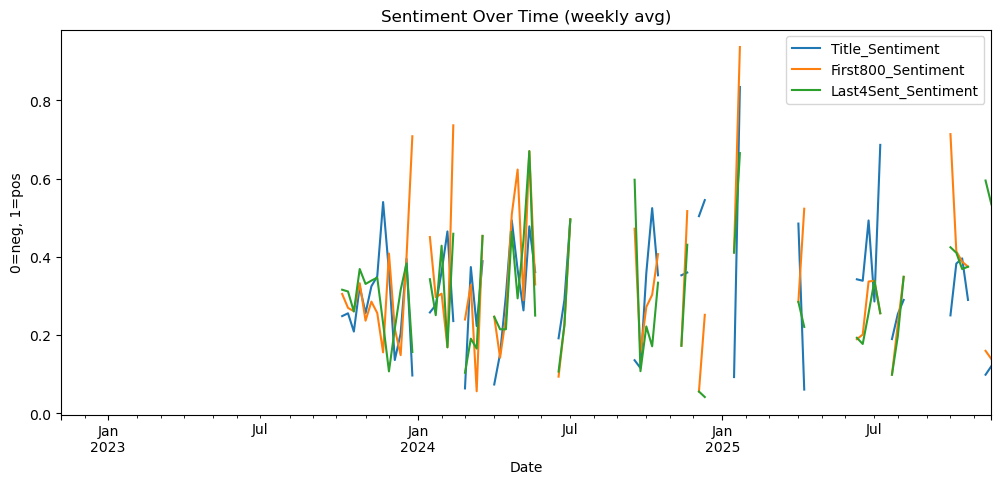

In [53]:
## Rebuild the plot
sent_cols = [c for c in ["Title_Sentiment","First800_Sentiment","Last4Sent_Sentiment"] if c in NewData_df.columns]

ts = (
    NewData_df
    .dropna(subset=["Date"])
    .sort_values("Date")
    .set_index("Date")[sent_cols]
    .apply(pd.to_numeric, errors="coerce")
    .resample("W").mean()
)

ts.plot(figsize=(12,5), title="Sentiment Over Time (weekly avg)", ylabel="0=neg, 1=pos");

#### Creating Embeddings

In [74]:
## Point to latest saved dataset
# Point to your latest saved dataset
DATA_PATHS = [
    Path("NYT_with_sentiment_FINAL.parquet"),
    Path("artifacts/NYT_with_sentiment.parquet"),
    Path("NYT_with_sentiment_FINAL.csv"),
]

for p in DATA_PATHS:
    if p.exists():
        print("Loading:", p)
        if p.suffix == ".parquet":
            NewData_df = pd.read_parquet(p)
        else:
            NewData_df = pd.read_csv(p)
        break
else:
    raise FileNotFoundError("Could not find a saved dataset. Update DATA_PATHS or load your DataFrame first.")


Loading: NYT_with_sentiment_FINAL.parquet


In [75]:
# ---- Choose your text source for retrieval ----
TITLE_COL = "Title"
PARA_COL  = "First Paragraph"  # change to your full text column later if you have it
DATE_COL  = "Date"             # must be a datetime64[ns] or parseable
AUTH_COL  = "Author"

In [76]:
# Build a single text field to embed (title + first para)
def make_doc(row):
    t = str(row.get(TITLE_COL, "") or "")
    p = str(row.get(PARA_COL, "") or "")
    return (t + "\n\n" + p).strip()

NewData_df["__doc_text"] = NewData_df.apply(make_doc, axis=1)
NewData_df[DATE_COL] = pd.to_datetime(NewData_df[DATE_COL], errors="coerce")

print("Rows:", len(NewData_df))
NewData_df[[TITLE_COL, AUTH_COL, DATE_COL, "__doc_text"]].head(2)

Rows: 291


,Title,Author,Date,__doc_text
0,Why Mamdani Frightens Jews Like Me,Bret Stephens,1970-01-01 00:00:00.000045952,Why Mamdani Frightens Jews Like Me\n\nA recent...
1,Why Israel Won the War,Bret Stephens,1970-01-01 00:00:00.000045944,Why Israel Won the War\n\nThough it seems absu...


In [77]:
## Fix dates
# Convert date column back from Excel serial format
NewData_df["Date"] = pd.to_numeric(NewData_df["Date"], errors="coerce")
NewData_df["Date"] = pd.to_datetime(NewData_df["Date"], unit="D", origin="1899-12-30")

In [78]:
## Check Dates
NewData_df["Date"].head()
NewData_df["Date"].describe()

count                              291
mean     2024-08-08 11:52:34.639175168
min                2022-11-04 00:00:00
25%                2023-10-25 12:00:00
50%                2024-03-21 00:00:00
75%                2025-10-08 12:00:00
max                2025-11-19 00:00:00
Name: Date, dtype: object

In [79]:
## Save Fixed Dataset
NewData_df.to_parquet("NYT_with_sentiment_FIXED.parquet", index=False)

C:\Users\nicol\anaconda3\envs\test\lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


In [80]:
## Check
print(NewData_df["Date"].min(), "→", NewData_df["Date"].max())
print("Rows:", len(NewData_df), "Unique dates:", NewData_df["Date"].nunique())

2022-11-04 00:00:00 → 2025-11-19 00:00:00
Rows: 291 Unique dates: 143


#### Chunking the docs (Title and First Paragraph)

In [81]:
## Chunking the docs (Title and First Paragraph)
## Add'l Imports
from typing import List



In [82]:
## What to chunkj
TITLE_COL, PARA_COL, DATE_COL, AUTH_COL = "Title", "First Paragraph", "Date", "Author"

In [83]:
## Cleaning
def clean_text(s: str) -> str:
    s = s.replace("\u00A0", " ")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\s+\n", "\n", s)
    return s.strip()

In [84]:
## Cleaning
def sentence_chunks(s: str, max_chars=1200, overlap_chars=200) -> List[str]:
    s = clean_text(s)
    pieces = re.split(r'(?<=[.!?])\s+|\n{2,}', s)  # sentence-ish splits
    chunks, buf = [], ""
    for sent in pieces:
        sent = sent.strip()
        if not sent: 
            continue
        if len(buf) + len(sent) + 1 <= max_chars:
            buf = f"{buf} {sent}".strip()
        else:
            if buf: chunks.append(buf)
            buf = sent
    if buf: chunks.append(buf)
    # simple overlap
    with_overlap = []
    for i, ch in enumerate(chunks):
        prev_tail = chunks[i-1][-overlap_chars:] if i > 0 else ""
        with_overlap.append((prev_tail + " " + ch).strip())
    return with_overlap

In [85]:
## Cleaning
def make_doc(row):
    t = str(row.get(TITLE_COL, "") or "")
    p = str(row.get(PARA_COL, "") or "")
    return (t + "\n\n" + p).strip()

In [86]:
## Review
NewData_df["__doc_text"] = NewData_df.apply(make_doc, axis=1)

In [87]:
## Clean
records = []
for i, row in NewData_df.reset_index(drop=True).iterrows():
    txt = str(row["__doc_text"] or "")
    if not txt.strip(): 
        continue
    for j, ch in enumerate(sentence_chunks(txt, max_chars=1200, overlap_chars=200)):
        records.append({
            "row_id": int(i),
            "chunk_id": int(j),
            "title": str(row.get(TITLE_COL, "") or ""),
            "author": str(row.get(AUTH_COL, "") or ""),
            "date": row.get(DATE_COL),
            "text": ch
        })

In [88]:
## Review
chunks_df = pd.DataFrame(records)
print("Total chunks:", len(chunks_df), "Articles covered:", chunks_df["row_id"].nunique())
chunks_df.head(3)

Total chunks: 1039 Articles covered: 291


,row_id,chunk_id,title,author,date,text
0,0,0,Why Mamdani Frightens Jews Like Me,Bret Stephens,2025-10-22,Why Mamdani Frightens Jews Like Me\nA recent F...
1,1,0,Why Israel Won the War,Bret Stephens,2025-10-14,Why Israel Won the War\nThough it seems absurd...
2,2,0,What Israel Should Learn From Two Years of War,Bret Stephens,2025-10-07,What Israel Should Learn From Two Years of War...


In [89]:
## More models
import numpy as np, json
from pathlib import Path
import faiss
from openai import OpenAI

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.10 from "C:\Users\nicol\anaconda3\envs\test\python.exe"
  * The NumPy version is: "1.23.5"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


In [64]:
import sys
print(sys.executable)

C:\Users\nicol\anaconda3\envs\llmenv2\python.exe


In [65]:
try:
    import faiss
    print("FAISS is available ✅", faiss.__version__)
except Exception as e:
    print("FAISS not installed ❌")

FAISS not installed ❌


In [66]:
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [67]:
from typing import List, Dict, Any, Optional, Tuple

In [68]:
# Load the saved dataset
NewData2_df = pd.read_parquet("NYT_with_sentiment_FINAL.parquet")

In [69]:
## Verify
list(NewData2_df.columns)

['#',
 'Date',
 'Author',
 'Publication',
 'Title',
 'First Paragraph',
 'Anti-Semitic',
 'Not Anti-Semitic',
 'Anti-Israel',
 'Anti-Palestinian',
 'Not Anti-Palestinian',
 'Anti-Hamas',
 'Op-Ed',
 'Anti-Semtic Reason1',
 'Anti-Semtic Reason2',
 'title_word_count',
 'First_Para_word_count',
 'Title_Sentiment',
 'First800_Sentiment',
 'Last4Sent_Sentiment',
 'Netanyahu_FirstPara_Sentiment',
 'Bibi_FirstPara_Sentiment',
 'Hamas_FirstPara_Sentiment',
 'Israel_FirstPara_Sentiment',
 'Palestinian_FirstPara_Sentiment',
 'Gaza_FirstPara_Sentiment',
 'Ceasefire_FirstPara_Sentiment',
 'Trump_FirstPara_Sentiment']

In [70]:
# --- column names you told me ---
DATE_COL   = "Date"
AUTH_COL   = "Author"
PUB_COL    = "Publication"
TITLE_COL  = "Title"
PARA_COL   = "First Paragraph"
SENT_TITLE = "Title_Sentiment"       # numeric 0..1 (0.5 ≈ neutral)
SENT_PARA  = "First800_Sentiment"    # numeric 0..1 (0.5 ≈ neutral)

In [71]:
# --- make sure sentiment cols are numeric & add a combined helper ---
NewData2_df[SENT_TITLE] = pd.to_numeric(NewData2_df[SENT_TITLE], errors="coerce")
NewData2_df[SENT_PARA]  = pd.to_numeric(NewData2_df[SENT_PARA],  errors="coerce")
NewData2_df["Combined_Sentiment"] = NewData2_df[[SENT_TITLE, SENT_PARA]].mean(axis=1, skipna=True)

In [72]:
# --- weighted text (embed this only) ---
TITLE_WEIGHT = 2  # set to 1 if you don't want extra title weight
NewData2_df["text_combined_weighted"] = (
    (("Title: " + NewData2_df[TITLE_COL].fillna("").astype(str).str.strip() + ". ") * TITLE_WEIGHT) +
    "\n\nFirst Paragraph: " + NewData2_df[PARA_COL].fillna("").astype(str).str.strip()
)
TEXT_COL = "text_combined_weighted"

In [73]:
# --- parsed date (once) ---
from pandas.api.types import is_numeric_dtype

DATE_COL = "Date"  # your date column name

def _ensure_date_cols(df: pd.DataFrame, date_col: str = DATE_COL):
    s = df[date_col]

    # Excel serial dates (numeric days since 1899-12-30)
    if is_numeric_dtype(s):
        dt = pd.to_datetime(s, unit="D", origin="1899-12-30", errors="coerce")
    else:
        dt = pd.to_datetime(s, errors="coerce")

        # If too many failed parses and values look like excel serials
        if dt.isna().mean() > 0.5:
            s_str = s.astype(str)
            looks_serial = s_str.str.fullmatch(r"\d{5}").mean() > 0.5
            if looks_serial:
                dt = pd.to_datetime(s_str.astype(float), unit="D", origin="1899-12-30", errors="coerce")

    df["Date_dt"] = dt
    df["Date_display"] = df["Date_dt"].dt.strftime("%Y-%m-%d")

# run it once:
_ensure_date_cols(NewData2_df)

In [74]:
## Load embedding model
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [75]:
# load model once
try:
    model
except NameError:
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

In [76]:
# (Re)build embeddings only if missing or row count changed
need_embed = ("embeddings" not in globals()) or (len(embeddings) != len(NewData2_df))
if need_embed:
    texts = NewData2_df[TEXT_COL].fillna("").tolist()
    embeddings = model.encode(texts, show_progress_bar=True, normalize_embeddings=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.30it/s]


In [77]:
# Fit NN index
nn = NearestNeighbors(n_neighbors=5, metric="cosine")
nn.fit(embeddings)

,n_neighbors,5
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [78]:
## Verify
list(NewData2_df.columns)

['#',
 'Date',
 'Author',
 'Publication',
 'Title',
 'First Paragraph',
 'Anti-Semitic',
 'Not Anti-Semitic',
 'Anti-Israel',
 'Anti-Palestinian',
 'Not Anti-Palestinian',
 'Anti-Hamas',
 'Op-Ed',
 'Anti-Semtic Reason1',
 'Anti-Semtic Reason2',
 'title_word_count',
 'First_Para_word_count',
 'Title_Sentiment',
 'First800_Sentiment',
 'Last4Sent_Sentiment',
 'Netanyahu_FirstPara_Sentiment',
 'Bibi_FirstPara_Sentiment',
 'Hamas_FirstPara_Sentiment',
 'Israel_FirstPara_Sentiment',
 'Palestinian_FirstPara_Sentiment',
 'Gaza_FirstPara_Sentiment',
 'Ceasefire_FirstPara_Sentiment',
 'Trump_FirstPara_Sentiment',
 'Combined_Sentiment',
 'text_combined_weighted',
 'Date_dt',
 'Date_display']

In [79]:
## Sentiment helpers and final
NEUTRAL_EPS = 0.02  # neutral band = 0.48–0.52

def _label_from_score(x: float):
    if pd.isna(x): return None
    if x < 0.5 - NEUTRAL_EPS: return "negative"
    if x > 0.5 + NEUTRAL_EPS: return "positive"
    return "neutral"

def _mask_by_label(df: pd.DataFrame, label: str, field: str = "either"):
    label = label.lower()
    t = df[SENT_TITLE].apply(_label_from_score) if SENT_TITLE in df.columns else pd.Series(index=df.index, dtype=object)
    p = df[SENT_PARA].apply(_label_from_score)  if SENT_PARA  in df.columns else pd.Series(index=df.index, dtype=object)
    if field == "title": return t.eq(label).fillna(False)
    if field == "para":  return p.eq(label).fillna(False)
    return (t.eq(label) | p.eq(label)).fillna(False)

def _mask_by_numeric(df: pd.DataFrame, min_sent=None, max_sent=None, field: str = "either"):
    if field == "title" and SENT_TITLE in df.columns:
        s = df[SENT_TITLE]
    elif field == "para" and SENT_PARA in df.columns:
        s = df[SENT_PARA]
    else:
        s = df[[c for c in [SENT_TITLE, SENT_PARA] if c in df.columns]].max(axis=1, skipna=True)
    m = pd.Series(True, index=df.index)
    if min_sent is not None: m &= (s >= float(min_sent))
    if max_sent is not None: m &= (s <= float(max_sent))
    return m.fillna(False)



In [80]:
def semantic_search(
    query: str,
    top_k: int = 5,
    since: str | None = None,
    sentiment: str | None = None,   # "negative" | "neutral" | "positive" | None
    min_sent: float | None = None,  # numeric 0..1
    max_sent: float | None = None,  # numeric 0..1
    sent_field: str = "either"      # "either" | "title" | "para"
):
    q_emb = model.encode([query], normalize_embeddings=True)
    sims = cosine_similarity(q_emb, embeddings)[0]
    cand = NewData2_df.copy()
    cand["similarity"] = sims

    if since:
        since_ts = pd.to_datetime(since, errors="coerce")
        cand = cand[cand["Date_dt"] >= since_ts]  # uses Date_dt created AFTER loading parquet

    if sentiment is not None:
        cand = cand[_mask_by_label(cand, sentiment, field=sent_field)]

    if (min_sent is not None) or (max_sent is not None):
        cand = cand[_mask_by_numeric(cand, min_sent=min_sent, max_sent=max_sent, field=sent_field)]

    cand = cand.nlargest(top_k, "similarity")

    cols = [c for c in [
        "similarity",
        "Date_display",  # pretty date for table
        PUB_COL, AUTH_COL, TITLE_COL,
        TEXT_COL,
        SENT_TITLE, SENT_PARA, "Combined_Sentiment"
    ] if c in cand.columns]

    out = cand[cols].copy()
    if TEXT_COL in out.columns:
        out["preview"] = out[TEXT_COL].astype(str).str.slice(0, 280) + "…"
        ordered = [c for c in [
            "similarity", "Date_display", PUB_COL, AUTH_COL, TITLE_COL, "preview",
            SENT_TITLE, SENT_PARA, "Combined_Sentiment"
        ] if c in out.columns]
        out = out[ordered + [c for c in out.columns if c not in ordered]]
    return out

In [81]:
semantic_search("Summarize Benjamin Netanyahu", top_k=5)

,similarity,Date_display,Publication,Author,Title,preview,Title_Sentiment,First800_Sentiment,Combined_Sentiment,text_combined_weighted
254,0.714689,2023-10-10,The New York Times,Steven Erlanger,"As War Rages, Netanyahu Battles for Reputation...","Title: As War Rages, Netanyahu Battles for Rep...",0.300,0.094,0.197,"Title: As War Rages, Netanyahu Battles for Rep..."
142,0.676305,2025-04-08,The New York Times,Thomas Friedman,Trump and Netanyahu Steer Toward an Ugly World...,Title: Trump and Netanyahu Steer Toward an Ugl...,0.061,0.523,0.292,Title: Trump and Netanyahu Steer Toward an Ugl...
121,0.659043,2025-10-12,The New York Times,Shira Efron,The Uncomfortable Truth About Netanyahu’s ‘Vic...,Title: The Uncomfortable Truth About Netanyahu...,0.204,0.338,0.271,Title: The Uncomfortable Truth About Netanyahu...
154,0.657920,2024-09-03,The New York Times,Thomas Friedman,"How Netanyahu Is Trying to Save Himself, Elect...",Title: How Netanyahu Is Trying to Save Himself...,0.361,0.141,0.251,Title: How Netanyahu Is Trying to Save Himself...
36,0.595886,2024-03-15,The New York Times,Bret Stephens,Schumer’s Blast at Netanyahu Might Have an Uni...,Title: Schumer’s Blast at Netanyahu Might Have...,0.263,0.045,0.154,Title: Schumer’s Blast at Netanyahu Might Have...


In [82]:
semantic_search("Summarize Benjamin Netanyahu", top_k=5, since="2024-01-01")

,similarity,Date_display,Publication,Author,Title,preview,Title_Sentiment,First800_Sentiment,Combined_Sentiment,text_combined_weighted
142,0.676305,2025-04-08,The New York Times,Thomas Friedman,Trump and Netanyahu Steer Toward an Ugly World...,Title: Trump and Netanyahu Steer Toward an Ugl...,0.061,0.523,0.2920,Title: Trump and Netanyahu Steer Toward an Ugl...
121,0.659043,2025-10-12,The New York Times,Shira Efron,The Uncomfortable Truth About Netanyahu’s ‘Vic...,Title: The Uncomfortable Truth About Netanyahu...,0.204,0.338,0.2710,Title: The Uncomfortable Truth About Netanyahu...
154,0.657920,2024-09-03,The New York Times,Thomas Friedman,"How Netanyahu Is Trying to Save Himself, Elect...",Title: How Netanyahu Is Trying to Save Himself...,0.361,0.141,0.2510,Title: How Netanyahu Is Trying to Save Himself...
36,0.595886,2024-03-15,The New York Times,Bret Stephens,Schumer’s Blast at Netanyahu Might Have an Uni...,Title: Schumer’s Blast at Netanyahu Might Have...,0.263,0.045,0.1540,Title: Schumer’s Blast at Netanyahu Might Have...
171,0.593367,2024-01-19,The New York Times,Thomas Friedman,Netanyahu Is Turning Against Biden,Title: Netanyahu Is Turning Against Biden. Tit...,0.225,0.444,0.3345,Title: Netanyahu Is Turning Against Biden. Tit...


In [83]:
semantic_search("Summarize Benjamin Netanyahu", top_k=5, sentiment="negative")

,similarity,Date_display,Publication,Author,Title,preview,Title_Sentiment,First800_Sentiment,Combined_Sentiment,text_combined_weighted
254,0.714689,2023-10-10,The New York Times,Steven Erlanger,"As War Rages, Netanyahu Battles for Reputation...","Title: As War Rages, Netanyahu Battles for Rep...",0.300,0.094,0.197,"Title: As War Rages, Netanyahu Battles for Rep..."
142,0.676305,2025-04-08,The New York Times,Thomas Friedman,Trump and Netanyahu Steer Toward an Ugly World...,Title: Trump and Netanyahu Steer Toward an Ugl...,0.061,0.523,0.292,Title: Trump and Netanyahu Steer Toward an Ugl...
121,0.659043,2025-10-12,The New York Times,Shira Efron,The Uncomfortable Truth About Netanyahu’s ‘Vic...,Title: The Uncomfortable Truth About Netanyahu...,0.204,0.338,0.271,Title: The Uncomfortable Truth About Netanyahu...
154,0.657920,2024-09-03,The New York Times,Thomas Friedman,"How Netanyahu Is Trying to Save Himself, Elect...",Title: How Netanyahu Is Trying to Save Himself...,0.361,0.141,0.251,Title: How Netanyahu Is Trying to Save Himself...
36,0.595886,2024-03-15,The New York Times,Bret Stephens,Schumer’s Blast at Netanyahu Might Have an Uni...,Title: Schumer’s Blast at Netanyahu Might Have...,0.263,0.045,0.154,Title: Schumer’s Blast at Netanyahu Might Have...


In [84]:
##

In [85]:
# If you haven't: pip install openai sentence-transformers
try:
    from openai import OpenAI
    _OPENAI_OK = True
except Exception:
    _OPENAI_OK = False

In [86]:
## Helpers
def _init_openai_client() -> Optional[Any]:
    """Initialize the OpenAI client if OPENAI_API_KEY is available."""
    if not _OPENAI_OK:
        return None
    if not (os.environ.get("OPENAI_API_KEY") or os.environ.get("openai_api_key")):
        return None
    try:
        return OpenAI()
    except Exception:
        return None

In [87]:
## Rename and assign model
TEXT_COL = "text_combined_weighted"   # make sure this matches your dataset cell

# Load the same model we originally used
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Recreate embeddings if needed
texts = NewData2_df[TEXT_COL].fillna("").astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True, normalize_embeddings=True)

print("✅ Embeddings rebuilt. Shape:", embeddings.shape)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.20it/s]

✅ Embeddings rebuilt. Shape: (291, 384)


In [88]:
def _format_context_for_prompt(ev_df: pd.DataFrame, max_chars: int = 12000) -> Tuple[str, List[Dict[str, Any]]]:
    """
    Build a compact, citation-friendly block from your evidence table.
    We number rows [1..k] so the model can cite them like [1], [2-3].
    """
    # pick sensible columns if available
    cols = {
        "date":       "Date_display" if "Date_display" in ev_df.columns else None,
        "pub":        PUB_COL if PUB_COL in ev_df.columns else None,
        "author":     AUTH_COL if AUTH_COL in ev_df.columns else None,
        "title":      TITLE_COL if TITLE_COL in ev_df.columns else None,
        "preview":    "preview" if "preview" in ev_df.columns else TEXT_COL if TEXT_COL in ev_df.columns else None,
        "sent":       "Combined_Sentiment" if "Combined_Sentiment" in ev_df.columns else None,
    }

    records = []
    for i, row in ev_df.reset_index(drop=True).iterrows():
        rec = {
            "id": i + 1,
            "date":   str(row.get(cols["date"], "")) if cols["date"] else "",
            "pub":    str(row.get(cols["pub"], "")) if cols["pub"] else "",
            "author": str(row.get(cols["author"], "")) if cols["author"] else "",
            "title":  str(row.get(cols["title"], "")) if cols["title"] else "",
            "sent":   row.get(cols["sent"], None) if cols["sent"] else None,
            "preview": str(row.get(cols["preview"], ""))[:800] if cols["preview"] else "",
        }
        records.append(rec)

    parts = []
    for r in records:
        sent_str = "" if (r["sent"] is None or pd.isna(r["sent"])) else f" | combined_sentiment={float(r['sent']):.3f}"
        parts.append(
            f"[{r['id']}] {r['date']} | {r['pub']} | {r['author']}\n"
            f"Title: {r['title']}{sent_str}\n"
            f"Preview: {r['preview']}"
        )
    context = "\n\n".join(parts)
    if len(context) > max_chars:
        context = context[:max_chars] + "\n...[truncated]"
    return context, records


In [89]:
## Define semantic saerch again clearly and alone

def semantic_search(
    query: str,
    top_k: int = 5,
    since: str | None = None,
    sentiment: str | None = None,   # "negative" | "neutral" | "positive" | None
    min_sent: float | None = None,  # numeric 0..1
    max_sent: float | None = None,  # numeric 0..1
    sent_field: str = "either"      # "either" | "title" | "para"
):
    # Embed query
    q_emb = model.encode([query], normalize_embeddings=True)
    
    # Cosine similarity
    sims = cosine_similarity(q_emb, embeddings)[0]

    # Build candidate frame
    cand = NewData2_df.copy()
    cand["similarity"] = sims

    # Filter by date if provided
    if since:
        since_ts = pd.to_datetime(since, errors="coerce")
        cand = cand[cand["Date_dt"] >= since_ts]

    # Filter by sentiment label if provided
    if sentiment is not None:
        cand = cand[_mask_by_label(cand, sentiment, field=sent_field)]

    # Filter by numeric sentiment bounds if provided
    if (min_sent is not None) or (max_sent is not None):
        cand = cand[_mask_by_numeric(cand, min_sent=min_sent, max_sent=max_sent, field=sent_field)]

    # Take top-k highest similarity
    cand = cand.nlargest(top_k, "similarity")

    # Pick columns to show
    cols = [
        "similarity",
        "Date_display", "Publication", "Author", "Title",
        "text_combined_weighted",
        SENT_TITLE, SENT_PARA, "Combined_Sentiment"
    ]
    cols = [c for c in cols if c in cand.columns]

    out = cand[cols].copy()

    # Add preview for readability
    out["preview"] = out["text_combined_weighted"].astype(str).str.slice(0, 280) + "…"

    # Preferred output ordering
    ordered = [
        "similarity", "Date_display", "Publication", "Author", "Title", "preview",
        SENT_TITLE, SENT_PARA, "Combined_Sentiment"
    ]
    out = out[[c for c in ordered if c in out.columns]]

    return out.reset_index(drop=True)

In [90]:
semantic_search

<function __main__.semantic_search(query: str, top_k: int = 5, since: str | None = None, sentiment: str | None = None, min_sent: float | None = None, max_sent: float | None = None, sent_field: str = 'either')>

In [91]:
# Cell 3A — get evidence rows using *your* semantic_search()
def _get_evidence(
    question: str,
    top_k: int = 8,
    since: str | None = None,
    sentiment: str | None = None,
    min_sent: float | None = None,
    max_sent: float | None = None,
    sent_field: str = "either",
):
    """Return top-K semantic search results as a DataFrame."""
    ev = semantic_search(
        query=question,
        top_k=top_k,
        since=since,
        sentiment=sentiment,
        min_sent=min_sent,
        max_sent=max_sent,
        sent_field=sent_field
    )
    return ev

In [92]:
# Cell 3B — build the prompt text using your formatting helper
def _build_prompt(question: str, evidence_df: pd.DataFrame) -> Tuple[str, str]:
    """
    Returns (system_message, user_message) for the OpenAI call.
    """
    context, _ = _format_context_for_prompt(evidence_df)

    system = (
        "You are a careful analyst. Answer ONLY from the provided article snippets. "
        "Keep it concise (3–6 sentences). Include inline citations like [1], [2-3]. "
        "If there isn't enough evidence, explicitly say so."
    )

    user = (
        f"Question: {question}\n\n"
        f"Sources:\n{context}\n\n"
        "Instructions:\n"
        "- Answer strictly from the sources above.\n"
        "- Include bracket citations with the source indices.\n"
        "- If sources conflict or are thin, note the uncertainty."
    )

    return system, user

In [93]:
# Cell 3C — final ask_openai (small now!)
# Patch: force a plain string model name & re-define ask_openai cleanly
OPENAI_MODEL_NAME = "gpt-4o-mini"  # <- keep this a literal string

def ask_openai(
    question: str,
    top_k: int = 8,
    since: str | None = None,
    sentiment: str | None = None,
    min_sent: float | None = None,
    max_sent: float | None = None,
    sent_field: str = "either",
    model_name: str = OPENAI_MODEL_NAME,
    temperature: float = 0.0,
):
    evidence = _get_evidence(
        question=question,
        top_k=top_k,
        since=since,
        sentiment=sentiment,
        min_sent=min_sent,
        max_sent=max_sent,
        sent_field=sent_field
    )
    system, user = _build_prompt(question, evidence)
    client = _init_openai_client()

    if client is None:
        return {
            "answer": "(OpenAI key not configured — showing evidence only)",
            "evidence": evidence
        }

    try:
        try:
            resp = client.responses.create(
                model=model_name,  # <- string, not `models.SOMETHING`
                input=[{"role": "system", "content": system},
                       {"role": "user", "content": user}],
                temperature=temperature,
            )
            answer = resp.output_text
        except Exception:
            chat = client.chat.completions.create(
                model=model_name,  # <- string again
                messages=[{"role":"system","content":system},
                          {"role":"user","content":user}],
                temperature=temperature,
            )
            answer = chat.choices[0].message.content
    except Exception as e:
        answer = f"(OpenAI call failed: {e})"

    return {"answer": answer, "evidence": evidence}

In [94]:
res = ask_openai("please give a summary of benjamin netanyahu", top_k=8)
print(res["answer"])
display(res["evidence"])

Benjamin Netanyahu, the Prime Minister of Israel, is currently facing significant challenges to his reputation and legacy, particularly due to the violent actions of Hamas against Israeli civilians, which are likely to define his tenure regardless of the war's outcome [1]. His leadership has been criticized, with calls for his resignation emerging amidst ongoing conflicts, suggesting a lack of confidence in his ability to govern effectively [5][6]. Additionally, Netanyahu's relationship with U.S. leadership has become strained, indicating a shift in political dynamics both domestically and internationally [7]. Overall, his legacy appears to be under scrutiny as he navigates these complex issues [1][4].


,similarity,Date_display,Publication,Author,Title,preview,Title_Sentiment,First800_Sentiment,Combined_Sentiment
0,0.689280,2023-10-10,The New York Times,Steven Erlanger,"As War Rages, Netanyahu Battles for Reputation...","Title: As War Rages, Netanyahu Battles for Rep...",0.300,0.094,0.1970
1,0.638513,2025-04-08,The New York Times,Thomas Friedman,Trump and Netanyahu Steer Toward an Ugly World...,Title: Trump and Netanyahu Steer Toward an Ugl...,0.061,0.523,0.2920
2,0.624119,2024-09-03,The New York Times,Thomas Friedman,"How Netanyahu Is Trying to Save Himself, Elect...",Title: How Netanyahu Is Trying to Save Himself...,0.361,0.141,0.2510
3,0.615927,2025-10-12,The New York Times,Shira Efron,The Uncomfortable Truth About Netanyahu’s ‘Vic...,Title: The Uncomfortable Truth About Netanyahu...,0.204,0.338,0.2710
4,0.603054,2024-03-15,The New York Times,Bret Stephens,Schumer’s Blast at Netanyahu Might Have an Uni...,Title: Schumer’s Blast at Netanyahu Might Have...,0.263,0.045,0.1540
5,0.556063,2024-04-09,The New York Times,Bret Stephens,Netanyahu Must Go,Title: Netanyahu Must Go. Title: Netanyahu Mus...,0.076,0.268,0.1720
6,0.543939,2024-01-19,The New York Times,Thomas Friedman,Netanyahu Is Turning Against Biden,Title: Netanyahu Is Turning Against Biden. Tit...,0.225,0.444,0.3345
7,0.539320,2024-07-02,The New York Times,Bret Stephens,What Would a Better Israeli Prime Minister Do?,Title: What Would a Better Israeli Prime Minis...,0.494,0.496,0.4950


In [55]:
semantic_search

<function __main__.semantic_search(query: str, top_k: int = 5, since: str | None = None, sentiment: str | None = None, min_sent: float | None = None, max_sent: float | None = None, sent_field: str = 'either')>

In [95]:
res = ask_openai("please give a summary of what Thomas Friedman thinks would end the war", top_k=8)
print(res["answer"])
display(res["evidence"])

Thomas Friedman suggests that a strategic approach is necessary to end the Israel-Iran war, emphasizing the need for a peace plan that addresses underlying issues rather than just the immediate conflict. He believes that President Trump's peace plan could serve as a foundation for transforming the situation in Gaza and potentially leading to broader peace efforts in the region [1][4]. However, the effectiveness of such plans remains uncertain, as the complexities of the conflict and the ongoing occupation pose significant challenges [5].


,similarity,Date_display,Publication,Author,Title,preview,Title_Sentiment,First800_Sentiment,Combined_Sentiment
0,0.467748,2025-06-16,The New York Times,Thomas Friedman,The Smart Way for Trump to End the Israel-Iran...,Title: The Smart Way for Trump to End the Isra...,0.555,0.161,0.3580
1,0.458057,2025-10-13,The New York Times,Katrin Bennhold,A Reality Check on Peace,Title: A Reality Check on Peace. Title: A Real...,0.523,0.675,0.5990
2,0.450325,2025-10-12,The New York Times,Shira Efron,The Uncomfortable Truth About Netanyahu’s ‘Vic...,Title: The Uncomfortable Truth About Netanyahu...,0.204,0.338,0.2710
3,0.417272,2025-09-29,The New York Times,Thomas Friedman,Can the Trump Peace Plan Overcome Unprecedente...,Title: Can the Trump Peace Plan Overcome Unpre...,0.127,0.755,0.4410
4,0.413841,2025-10-15,The New York Times,Diana Buttu,What Trump’s Peace Deal Really Means for Gaza,Title: What Trump’s Peace Deal Really Means fo...,0.448,0.384,0.4160
5,0.404707,2024-05-09,The New York Times,Bret Stephens,President Biden Just Made His Biggest Blunder,Title: President Biden Just Made His Biggest B...,0.215,0.380,0.2975
6,0.403552,2025-06-13,The New York Times,Thomas Friedman,How to Think About What’s Happening With Iran ...,Title: How to Think About What’s Happening Wit...,0.345,0.234,0.2895
7,0.401200,2024-07-30,The New York Times,Bret Stephens,Israel’s Five Wars,Title: Israel’s Five Wars. Title: Israel’s Fiv...,0.324,0.277,0.3005


In [96]:
## Buiding out Unigrams, Bigrams, Trigrams and WordClouds

In [106]:
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

In [103]:
#STOPWORDS

In [265]:

# Start with WordCloud’s English stopwords
stopwords_base = set(w.lower() for w in STOPWORDS)

# Optional: add domain-specific stopwords (edit this list anytime)
extra_stopwords = {
    "nytimes", "new", "york", "times",    # publication boilerplate (if it ever sneaks in)
    "said", "say", "says",                # speech reporting
    "mr", "ms", "mrs", "title",            # honorifics
    "first", "el", "man", "fans" "dr", "something", "around",
    "paragraph",
    # add/remove terms as you see them in the top results
}

my_stopwords = stopwords_base | extra_stopwords
print(f"Stopwords loaded: {len(my_stopwords)} words")

Stopwords loaded: 210 words


In [266]:
# Normalize stopwords to match CountVectorizer tokenization behavior
import re

def normalize_stopwords(stopwords):
    norm = set()
    for w in stopwords:
        # Lowercase and strip punctuation/apostrophes the same way CountVectorizer does
        w = w.lower()
        w = re.sub(r"[^\w]", "", w)  # remove apostrophes and punctuation
        if len(w) > 1:  # avoid removing single-character tokens like 'a'
            norm.add(w)
    return norm

my_stopwords_norm = normalize_stopwords(my_stopwords)
print(f"Original stopwords: {len(my_stopwords)}")
print(f"Normalized stopwords: {len(my_stopwords_norm)}")

Original stopwords: 210
Normalized stopwords: 204


In [267]:
def extract_ngrams(
    texts,
    ngram_range=(1,1),
    min_df=0.002,          # appears in >=0.2% of articles
    max_df=0.95,           # ignore extremely common terms
    max_features=20000,    # vocabulary size cap
    stopwords=None,
    top_n=40,
):
    """
    Returns a pandas.Series of n-grams sorted by total corpus frequency.
    Uses sparse matrix counts (efficient), no densify.
    """
    vect = CountVectorizer(
        ngram_range=ngram_range,
        stop_words=stopwords,
        lowercase=True,
        token_pattern=r"(?u)\b\w\w+\b",
        min_df=min_df,
        max_df=max_df,
        max_features=max_features,
    )
    X = vect.fit_transform(texts)                     # sparse doc-term matrix
    counts = np.asarray(X.sum(axis=0)).ravel()        # total corpus counts
    vocab = np.array(vect.get_feature_names_out())
    order = np.argsort(-counts)[:top_n]               # top-N descending
    return pd.Series(counts[order], index=vocab[order], name="count")

In [268]:
## Unigrams start
TEXT_COL = "text_combined_weighted"
texts_all = NewData2_df[TEXT_COL].fillna("").astype(str).tolist()

top_unigrams = extract_ngrams(
    texts_all,
    ngram_range=(1,1),
    stopwords=list(my_stopwords),
    min_df=0.002,   # appears in ~0.2% of articles; adjust if too sparse or too common
    max_df=0.95,    # drop words appearing in almost everything
    top_n=40
)

display(top_unigrams.to_frame("count"))

C:\Users\nicol\anaconda3\envs\llmenv2\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


,count
israel,2450
gaza,1469
hamas,1459
israeli,1082
palestinian,779
war,778
will,660
iran,560
netanyahu,524
people,407


In [269]:
# Bigram and trigram extraction
TOP_N = 40   # adjust if you want more or fewer results

top_bigrams = extract_ngrams(
    texts_all,
    ngram_range=(2,2),
    stopwords=list(my_stopwords_norm),
    min_df=0.002,
    max_df=0.95,
    top_n=TOP_N
)

print("\nTop Bigrams:")
display(top_bigrams.to_frame("count"))


Top Bigrams:


,count
west bank,268
palestinian authority,191
saudi arabia,178
middle east,170
cease fire,167
prime minister,156
united states,131
israeli military,110
israel hamas,105
two state,100


In [270]:
top_trigrams = extract_ngrams(
    texts_all,
    ngram_range=(3,3),
    stopwords=list(my_stopwords_norm),
    min_df=0.002,
    max_df=0.95,
    top_n=TOP_N
)

print("Top Trigrams:")
display(top_trigrams.sort_values(ascending=False).to_frame("count"))

Top Trigrams:


,count
two state solution,90
minister benjamin netanyahu,68
prime minister benjamin,68
gaza west bank,36
west bank gaza,35
benjamin netanyahu israel,27
israeli prime minister,27
israel saudi arabia,23
united arab emirates,23
state antony blinken,23


In [271]:
top_unigrams.head(25)

israel          2450
gaza            1469
hamas           1459
israeli         1082
palestinian      779
war              778
will             660
iran             560
netanyahu        524
people           407
palestinians     405
one              399
military         387
two              387
state            366
arab             334
world            324
now              312
west             295
trump            292
bank             270
saudi            262
biden            244
states           243
many             242
Name: count, dtype: int64

In [272]:
top_bigrams.head(25)

west bank                268
palestinian authority    191
saudi arabia             178
middle east              170
cease fire               167
prime minister           156
united states            131
israeli military         110
israel hamas             105
two state                100
benjamin netanyahu        92
state solution            91
gaza strip                73
minister benjamin         68
palestinian state         65
president biden           58
israeli government        57
gaza war                  54
jewish state              50
united nations            48
attack israel             48
war gaza                  48
social media              47
israel will               46
far right                 46
Name: count, dtype: int64

In [273]:
top_trigrams.head(25)

two state solution                90
prime minister benjamin           68
minister benjamin netanyahu       68
gaza west bank                    36
west bank gaza                    35
benjamin netanyahu israel         27
israeli prime minister            27
secretary state antony            23
state antony blinken              23
israel saudi arabia               23
united arab emirates              23
gaza cease fire                   22
israel hamas war                  21
palestinian authority west        20
two states two                    20
authority west bank               20
palestinians west bank            19
normalize relations israel        19
shiite militias iraq              17
hamas hezbollah houthis           17
moderate arab states              16
cease fire deal                   16
al shifa hospital                 15
gaza health ministry              15
reformed palestinian authority    14
Name: count, dtype: int64

In [274]:
## test
NewData2_df.shape

(291, 33)

In [275]:
## Test
TEXT_COL

'text_combined_weighted'

In [276]:
my_stopwords_norm

{'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 'arent',
 'around',
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'cannot',
 'cant',
 'com',
 'could',
 'couldnt',
 'did',
 'didnt',
 'do',
 'does',
 'doesnt',
 'doing',
 'dont',
 'down',
 'during',
 'each',
 'el',
 'else',
 'ever',
 'fansdr',
 'few',
 'first',
 'for',
 'from',
 'further',
 'get',
 'had',
 'hadnt',
 'has',
 'hasnt',
 'have',
 'havent',
 'having',
 'he',
 'hed',
 'hell',
 'hence',
 'her',
 'here',
 'heres',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'how',
 'however',
 'hows',
 'http',
 'id',
 'if',
 'ill',
 'im',
 'in',
 'into',
 'is',
 'isnt',
 'it',
 'its',
 'itself',
 'ive',
 'just',
 'lets',
 'like',
 'man',
 'me',
 'more',
 'most',
 'mr',
 'mrs',
 'ms',
 'mustnt',
 'my',
 'myself',
 'new',
 'no',
 'nor',
 'not',
 'nytimes',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 '

In [277]:
top_unigrams.head()

israel         2450
gaza           1469
hamas          1459
israeli        1082
palestinian     779
Name: count, dtype: int64

In [278]:
import pickle

In [279]:
with open("analysis_state.pkl", "wb") as f:
    pickle.dump({
        "my_stopwords_norm": my_stopwords_norm,
        "top_unigrams": top_unigrams,
        "top_bigrams": top_bigrams,
        "top_trigrams": top_trigrams
    }, f)

print("✅ State saved.")

✅ State saved.


In [280]:
## How many authors
NewData2_df["Author"].value_counts()

Author
Thomas Friedman       62
Bret Stephens         56
Isabel Kershner       13
Aaron Boxerman         9
Adam Rasgon            8
                      ..
Cassandra Vinograd     1
Megan Specia           1
Maria Abi-Habib        1
Kayla Guo              1
Emma Bubola            1
Name: count, Length: 86, dtype: int64

In [281]:
## Step 1
AUTHOR_COL = "Author"
TEXT_COL = "text_combined_weighted"
TOP_N = 40  # change if you want more/less

In [282]:
## Step 2
def top_ngrams_by_author_df(df, ngram_range=(1,1), stopwords=None, top_n=TOP_N):
    rows = []
    for author, sub in df.groupby(AUTHOR_COL):
        texts = sub[TEXT_COL].fillna("").astype(str).tolist()
        if not any(texts):
            continue
            
        # IMPORTANT CHANGE: per-author frequency → min_df=1, max_df=1.0
        s = extract_ngrams(
            texts,
            ngram_range=ngram_range,
            stopwords=stopwords,
            min_df=1,       # was 0.002 — now require ≥1 occurrence
            max_df=1.0,     # was 0.95 — allow full author vocab
            top_n=top_n
        )
        
        n = ngram_range[0]
        for term, cnt in s.items():
            rows.append((author, term, int(cnt), n))
            
    return pd.DataFrame(rows, columns=["Author", "ngram", "count", "n"])

In [283]:
# Build all three in one go
author_unigrams = top_ngrams_by_author_df(NewData2_df, (1,1), stopwords=list(my_stopwords_norm))
author_bigrams  = top_ngrams_by_author_df(NewData2_df, (2,2), stopwords=list(my_stopwords_norm))
author_trigrams = top_ngrams_by_author_df(NewData2_df, (3,3), stopwords=list(my_stopwords_norm))

In [284]:
# Example peek
display(author_unigrams.sort_values(["Author","count"], ascending=[True,False]).head(30))
display(author_bigrams.sort_values(["Author","count"], ascending=[True,False]).head(30))
display(author_trigrams.sort_values(["Author","count"], ascending=[True,False]).head(30))

,Author,ngram,count,n
0,Aaron Boxerman,israel,40,1
1,Aaron Boxerman,gaza,36,1
2,Aaron Boxerman,israeli,34,1
3,Aaron Boxerman,hamas,23,1
4,Aaron Boxerman,military,20,1
5,Aaron Boxerman,palestinian,15,1
6,Aaron Boxerman,fire,12,1
7,Aaron Boxerman,saturday,11,1
8,Aaron Boxerman,militants,11,1
9,Aaron Boxerman,iran,9,1


,Author,ngram,count,n
0,Aaron Boxerman,israeli military,14,2
1,Aaron Boxerman,cease fire,9,2
2,Aaron Boxerman,islamic jihad,8,2
3,Aaron Boxerman,palestinian militants,7,2
4,Aaron Boxerman,united nations,4,2
5,Aaron Boxerman,israel hamas,4,2
6,Aaron Boxerman,gaza strip,4,2
7,Aaron Boxerman,gaza cease,4,2
8,Aaron Boxerman,northern gaza,4,2
9,Aaron Boxerman,ground invasion,4,2


,Author,ngram,count,n
0,Aaron Boxerman,gaza cease fire,4,3
1,Aaron Boxerman,palestinian rocket fire,3,3
2,Aaron Boxerman,fires vehicle saying,2,3
3,Aaron Boxerman,confirms deaths 15,2,3
4,Aaron Boxerman,much money aid,2,3
5,Aaron Boxerman,left done gaza,2,3
6,Aaron Boxerman,strikes central israel,2,3
7,Aaron Boxerman,done gaza cease,2,3
8,Aaron Boxerman,deaths 15 soldiers,2,3
9,Aaron Boxerman,saying crossed gaza,2,3


In [285]:
# If you’d like a single combined table, do 
pd.concat([author_unigrams, author_bigrams, author_trigrams], ignore_index=True)

,Author,ngram,count,n
0,Aaron Boxerman,israel,40,1
1,Aaron Boxerman,gaza,36,1
2,Aaron Boxerman,israeli,34,1
3,Aaron Boxerman,hamas,23,1
4,Aaron Boxerman,military,20,1
...,...,...,...,...
10103,Zolan Kanno-Youngs,groups palestinian territory,1,3
10104,Zolan Kanno-Youngs,hamas continued kill,1,3
10105,Zolan Kanno-Youngs,hamas fighters captured,1,3
10106,Zolan Kanno-Youngs,fighters captured video,1,3


In [286]:
## Author-distinctive terms with TF-IDF (no changes to prior code) This creates author-level “documents” and finds what each author emphasizes more than others. It doesn’t touch your earlier pipeline.

from sklearn.feature_extraction.text import TfidfVectorizer


In [287]:
# Build one doc per author (join all their rows)
author_docs = (
    NewData2_df
    .groupby(AUTHOR_COL)[TEXT_COL]
    .apply(lambda s: " ".join(s.dropna().astype(str)))
)

In [288]:
# Vectorize across authors (unigrams→trigrams), using the list-ified stopwords
tfidf_vec = TfidfVectorizer(
    stop_words=list(my_stopwords_norm),   # <-- this is the only needed fix
    ngram_range=(1,3),
    min_df=3
)

tfidf = tfidf_vec.fit_transform(author_docs)
terms = tfidf_vec.get_feature_names_out()
author_index = list(author_docs.index)

def distinctive_terms(author_name, top_n=20):
    i = author_index.index(author_name)
    row = tfidf[i].toarray().ravel()
    top_idx = row.argsort()[::-1][:top_n]
    return pd.DataFrame({
        "term": terms[top_idx],
        "tfidf": row[top_idx]
    })

# Example:
# display(distinctive_terms("Thomas Friedman", top_n=25))

In [289]:
## Example
display(distinctive_terms("Thomas Friedman", top_n=25))

,term,tfidf
0,israel,0.327538
1,iran,0.210795
2,netanyahu,0.173368
3,gaza,0.170977
4,hamas,0.168786
5,saudi,0.152623
6,war,0.151615
7,israeli,0.150789
8,will,0.148442
9,authority,0.131099


In [290]:
## What makes an author disttinctive

In [291]:
## Step A — Build a reusable distinctive-term table function
def author_distinctive_table(author_name, top_n=30):
    """
    Returns a clean formatted DataFrame showing the most distinctive 
    terms (uni/bi/tri-grams) for a given author based on TF-IDF.
    """
    i = author_index.index(author_name)
    row = tfidf[i].toarray().ravel()

    top_idx = row.argsort()[::-1][:top_n]  # highest TF-IDF scores
    df = pd.DataFrame({
        "term": terms[top_idx],
        "tfidf_score": row[top_idx]
    })

    # Add interpretation by TF-IDF strength
    def interpret(score):
        if score >= 0.35:
            return "Strongly distinctive — core topic/framing"
        elif score >= 0.15:
            return "Distinctive — notable emphasis"
        elif score >= 0.05:
            return "Mildly distinctive — moderate emphasis"
        else:
            return "Common / shared vocabulary"

    df["interpretation"] = df["tfidf_score"].apply(interpret)

    return df[["term", "tfidf_score", "interpretation"]]


In [292]:
## Example
display(author_distinctive_table("Thomas Friedman", top_n=25))

,term,tfidf_score,interpretation
0,israel,0.327538,Distinctive — notable emphasis
1,iran,0.210795,Distinctive — notable emphasis
2,netanyahu,0.173368,Distinctive — notable emphasis
3,gaza,0.170977,Distinctive — notable emphasis
4,hamas,0.168786,Distinctive — notable emphasis
5,saudi,0.152623,Distinctive — notable emphasis
6,war,0.151615,Distinctive — notable emphasis
7,israeli,0.150789,Distinctive — notable emphasis
8,will,0.148442,Mildly distinctive — moderate emphasis
9,authority,0.131099,Mildly distinctive — moderate emphasis


In [293]:
## Distinctive over time
NewData2_df.columns

Index(['#', 'Date', 'Author', 'Publication', 'Title', 'First Paragraph',
       'Anti-Semitic', 'Not Anti-Semitic', 'Anti-Israel', 'Anti-Palestinian',
       'Not Anti-Palestinian', 'Anti-Hamas', 'Op-Ed', 'Anti-Semtic Reason1',
       'Anti-Semtic Reason2', 'title_word_count', 'First_Para_word_count',
       'Title_Sentiment', 'First800_Sentiment', 'Last4Sent_Sentiment',
       'Netanyahu_FirstPara_Sentiment', 'Bibi_FirstPara_Sentiment',
       'Hamas_FirstPara_Sentiment', 'Israel_FirstPara_Sentiment',
       'Palestinian_FirstPara_Sentiment', 'Gaza_FirstPara_Sentiment',
       'Ceasefire_FirstPara_Sentiment', 'Trump_FirstPara_Sentiment',
       'Combined_Sentiment', 'text_combined_weighted', 'Date_dt',
       'Date_display', 'Year'],
      dtype='object')

In [294]:
#Assuming the date column is named "date" → we do:
NewData2_df["Year"] = pd.to_datetime(NewData2_df["Date_display"]).dt.year

In [295]:
# Build doc per author per year
author_year_docs = (
    NewData2_df
    .groupby(["Author", "Year"])["text_combined_weighted"]
    .apply(lambda s: " ".join(s.dropna().astype(str)))
    .reset_index()
)

In [296]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec_year = TfidfVectorizer(
    stop_words=list(my_stopwords_norm),
    ngram_range=(1,3),
    min_df=3
)

X = tfidf_vec_year.fit_transform(author_year_docs["text_combined_weighted"])
terms_year = tfidf_vec_year.get_feature_names_out()

In [297]:
## Function to Show Distinctive Terms for One Author Over Time
def author_over_time(author_name, top_n=20):
    sub = author_year_docs[author_year_docs["Author"] == author_name]
    if sub.empty:
        return None

    rows = []
    for idx, row in sub.iterrows():
        vec = X[idx].toarray().ravel()
        top_idx = vec.argsort()[::-1][:top_n]
        for i in top_idx:
            rows.append((author_name, row["Year"], terms_year[i], vec[i]))

    df = pd.DataFrame(rows, columns=["Author", "Year", "term", "tfidf_score"])
    return df.sort_values(["Year", "tfidf_score"], ascending=[True, False])


In [298]:
## Example
display(author_over_time("Thomas Friedman", top_n=15))

,Author,Year,term,tfidf_score
0,Thomas Friedman,2022,netanyahu,0.279909
1,Thomas Friedman,2022,israeli,0.218658
2,Thomas Friedman,2022,israel,0.186074
3,Thomas Friedman,2022,arab,0.174755
4,Thomas Friedman,2022,jewish,0.170128
5,Thomas Friedman,2022,arabs,0.166819
6,Thomas Friedman,2022,israeli arab,0.154622
7,Thomas Friedman,2022,election,0.154622
8,Thomas Friedman,2022,percent,0.151794
9,Thomas Friedman,2022,barnea,0.142516


In [299]:
## Create safe export
import os

EXPORT_DIR = "./exports/distinctive_terms"
os.makedirs(EXPORT_DIR, exist_ok=True)

In [300]:
for author in author_index:
    out = author_distinctive_table(author, top_n=40)
    safe = "".join(c for c in author if c.isalnum() or c in (" ","_","-")).strip().replace(" ","_")
    out.to_csv(f"{EXPORT_DIR}/distinctive_terms_{safe}.csv", index=False)

In [301]:
EXPORT_TIME_DIR = "./exports/distinctive_terms_over_time"
os.makedirs(EXPORT_TIME_DIR, exist_ok=True)

for author in author_index:
    df = author_over_time(author, top_n=25)
    if df is None:
        continue
    safe = "".join(c for c in author if c.isalnum() or c in (" ","_","-")).strip().replace(" ","_")
    df.to_csv(f"{EXPORT_TIME_DIR}/distinctive_terms_over_time_{safe}.csv", index=False)

In [302]:
## Create heatmap


In [303]:
## imports
import matplotlib.pyplot as plt
import seaborn as sns

In [304]:
## Heatmap function
def plot_author_heatmap(author_name, top_n=25):
    # Get the author-year distinctive terms table
    df = author_over_time(author_name, top_n=top_n)
    if df is None or df.empty:
        print(f"No data available for author: {author_name}")
        return
    
    # Keep only the distinctive mid/high terms to avoid clutter
    df = df[df["tfidf_score"] >= 0.05]
    
    # Pivot into matrix: rows = terms, columns = year
    pivot = df.pivot_table(
        index="term",
        columns="Year",
        values="tfidf_score",
        aggfunc="max",  # highest distinctiveness in that year
        fill_value=0
    )
    
    # Sort terms by overall importance (sum TF-IDF across years)
    pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
    
    # Plot
    plt.figure(figsize=(12, max(6, len(pivot) * 0.35)))
    sns.heatmap(pivot, cmap="YlOrRd", linewidths=.5)
    plt.title(f"Distinctive Framing Over Time — {author_name}", fontsize=18)
    plt.xlabel("Year")
    plt.ylabel("Distinctive Terms")
    plt.tight_layout()
    plt.show()

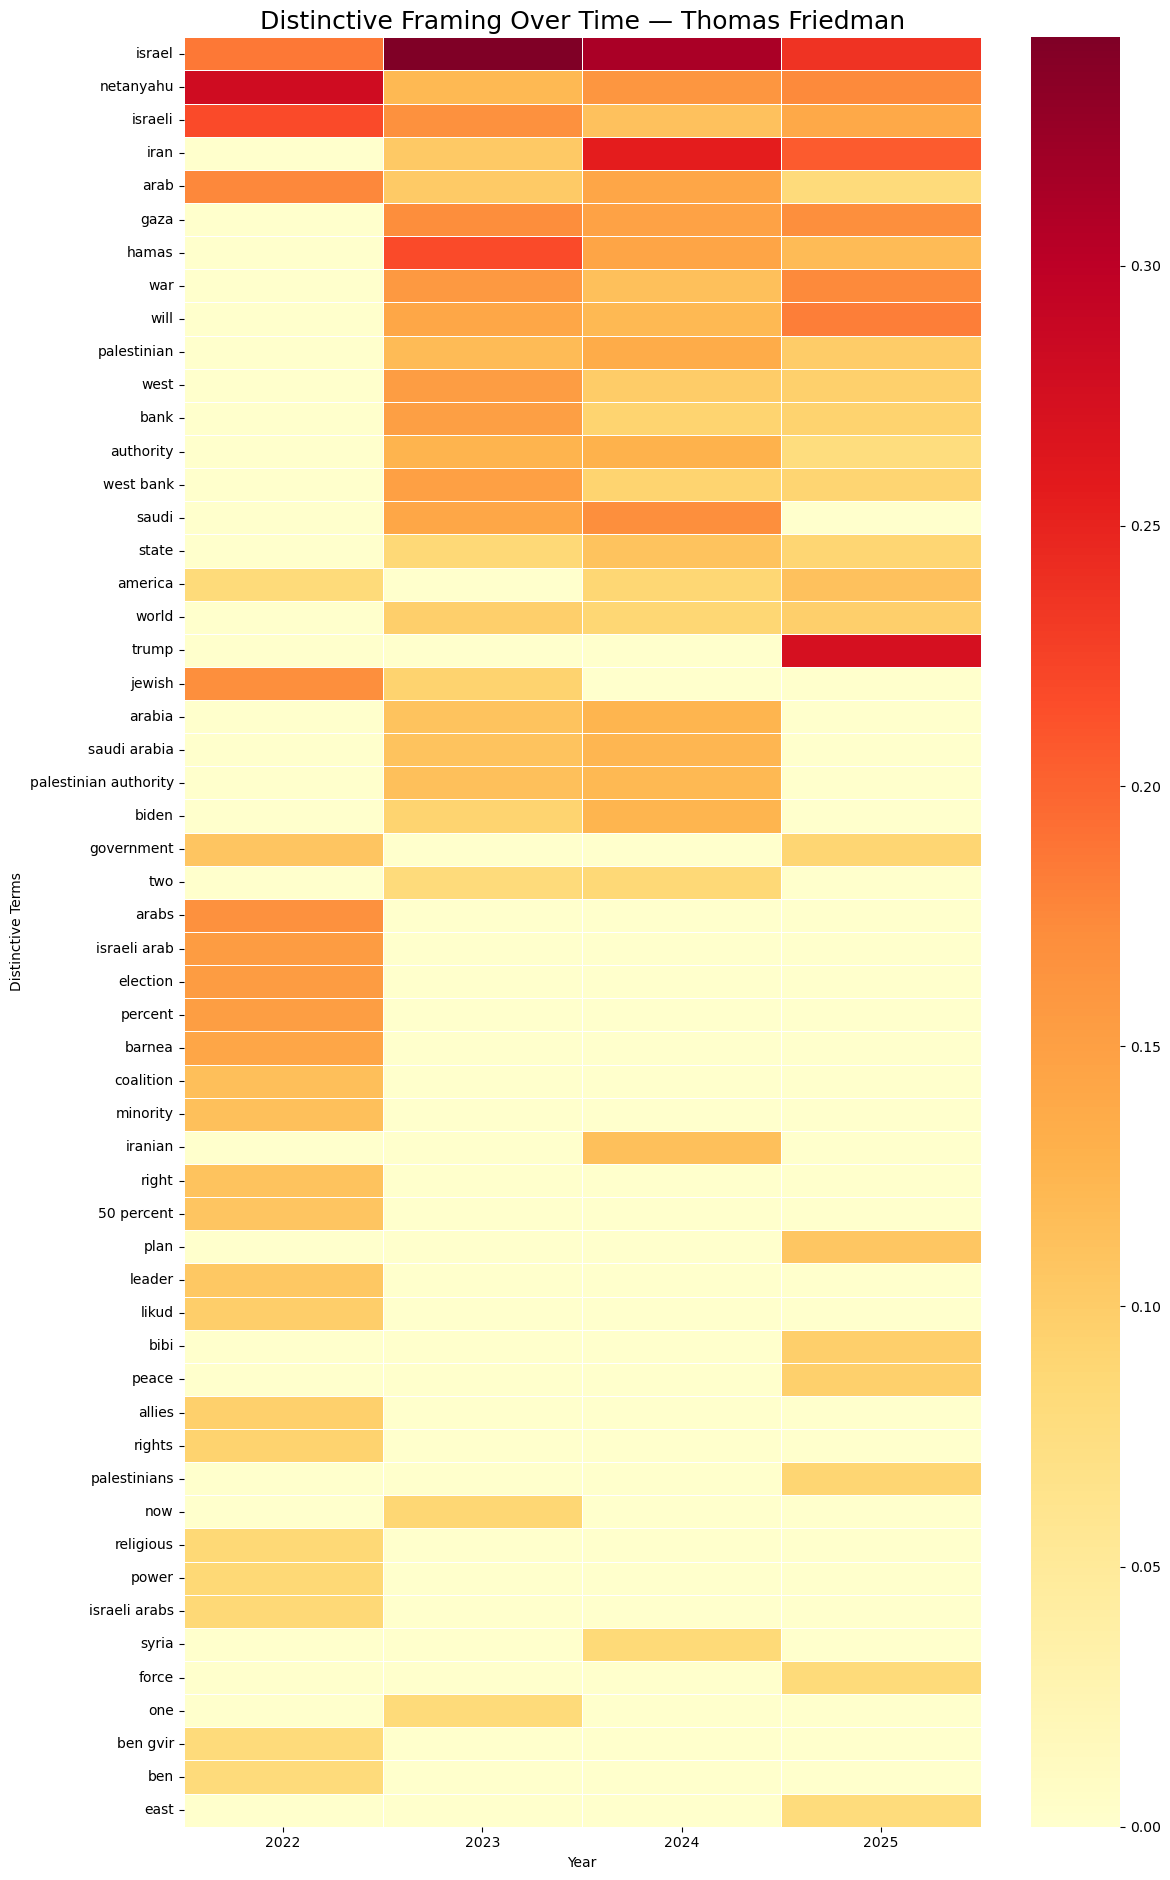

In [305]:
## Use the heatmap
plot_author_heatmap("Thomas Friedman", top_n=25)

In [306]:
## Comparing Authors TFIDF across terms
## Terms of interest
terms_of_interest = [
    "israel",
    "gaza",
    "west bank",
    "netanyahu",
    "hamas",
    "palestinian authority",
    "hezbollah",
    "iran"
]


In [307]:
## Step 2 — Convert TF-IDF Matrix to a DataFrame for These Terms
def build_focus_table(terms_list):
    # Only keep terms that actually exist in the TF-IDF vocabulary
    existing = [t for t in terms_list if t in terms]
    
    if not existing:
        raise ValueError("None of the selected terms are in the TF-IDF vocabulary.")
    
    # Get column indices for the selected terms
    col_idx = [list(terms).index(t) for t in existing]
    
    # Slice TF-IDF matrix (convert to dense per selected columns only)
    submatrix = tfidf[:, col_idx].toarray()
    
    # Build DataFrame
    df = pd.DataFrame(submatrix, columns=existing, index=author_index)
    
    return df

focus_table = build_focus_table(terms_of_interest)
display(focus_table)

,israel,gaza,west bank,netanyahu,hamas,palestinian authority,hezbollah,iran
Aaron Boxerman,0.238410,0.224737,0.042001,0.033136,0.141926,0.000000,0.015366,0.118462
Adam Entous,0.040582,0.127516,0.190652,0.000000,0.000000,0.000000,0.000000,0.089620
Adam Goldman,0.131869,0.138118,0.000000,0.000000,0.187722,0.000000,0.000000,0.000000
Adam Rasgon,0.112097,0.266840,0.000000,0.000000,0.137156,0.000000,0.000000,0.000000
Andrew Ross,0.124876,0.087196,0.097776,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
Tiffany May,0.175802,0.133915,0.037541,0.000000,0.297834,0.098722,0.041204,0.070588
Vivian Nereim,0.191235,0.091803,0.018717,0.029532,0.032998,0.000000,0.020543,0.105579
Vivian Yee,0.159205,0.148222,0.000000,0.000000,0.137356,0.000000,0.000000,0.000000
Yan Zhuang,0.034980,0.109912,0.000000,0.000000,0.036215,0.000000,0.000000,0.000000


In [308]:
## Sort option
focus_table.sort_values(by="israel", ascending=False).head(15)

,israel,gaza,west bank,netanyahu,hamas,palestinian authority,hezbollah,iran
Bret Stephens,0.337092,0.119160,0.000000,0.085895,0.161410,0.013014,0.086908,0.074442
Thomas Friedman,0.327538,0.170977,0.118556,0.173368,0.168786,0.118055,0.075135,0.210795
Matthew Mpoke Bigg,0.269248,0.108464,0.000000,0.038382,0.160820,0.000000,0.000000,0.022869
Isabel Kershner,0.245793,0.210634,0.000000,0.024845,0.198951,0.000000,0.069130,0.000000
Aaron Boxerman,0.238410,0.224737,0.042001,0.033136,0.141926,0.000000,0.015366,0.118462
Farnaz Fassihi,0.219890,0.122505,0.000000,0.000000,0.125936,0.000000,0.072372,0.454601
Steven Erlanger,0.213483,0.117684,0.026393,0.229043,0.279185,0.000000,0.000000,0.000000
Maria Abi-Habib,0.212852,0.148626,0.000000,0.000000,0.128548,0.000000,0.000000,0.000000
Patrick Kingsley,0.212561,0.215212,0.033286,0.052521,0.110033,0.000000,0.036534,0.031294
Julian Barnes,0.211255,0.070805,0.000000,0.046979,0.201217,0.000000,0.000000,0.000000


In [309]:
## Save to CSV
focus_table.to_csv("./exports/author_issue_emphasis_table.csv")

In [310]:
## Extract 3 top distinctive terms by author
top3_terms = {}

for author in author_index:   # uses the same ordering TF-IDF was built on
    df = distinctive_terms(author, top_n=3)  # this already outputs a table
    top3_terms[author] = list(df["term"])    # take the top 3 terms



In [311]:
## Check Dictionary
top3_terms

{'Aaron Boxerman': ['israeli', 'israel', 'gaza'],
 'Adam Entous': ['blinken', 'iraqi', 'visits'],
 'Adam Goldman': ['tunnels', 'hamas', 'hide'],
 'Adam Rasgon': ['gaza', 'gaza deal', 'deal'],
 'Andrew Ross': ['israel gaza war', 'always', 'third'],
 'Andrew Ross Sorkin': ['rebuild', 'cost', 'fire israel hamas'],
 'Anemona Hartocollis': ['harvard', 'university', 'student'],
 'Aurelien Breeden': ['without', 'fight', 'rules'],
 'Ben Hubbard': ['hezbollah', 'nasrallah', 'lebanon'],
 'Benzion Sanders': ['unit', 'fought', 'palestinian'],
 'Bernie Sanders': ['must', 'palestinians', 'israel'],
 'Binod Ghimire': ['captive', 'son', 'town'],
 'Bret Stephens': ['israel', 'jews', 'hamas'],
 'Cassandra Vinograd': ['hospital', 'al', 'al shifa'],
 'Chelsia Rose Marcius': ['pro', 'demonstrators', 'pro palestinian'],
 'Dana Stroul': ['trump', 'factor', 'success'],
 'Daniel Kurtzer': ['egypt', 'humanitarian', 'gaza'],
 'David Halbfinger': ['prisoners', 'hostages prisoners', 'trump'],
 'David Sanger': ['pe

In [312]:
## Step 3 convert into DF and merge into dataset
top3_df = pd.DataFrame.from_dict(top3_terms, orient="index", columns=["term1", "term2", "term3"])
top3_df.index.name = "Author"
top3_df = top3_df.reset_index()   # now Author is a normal column

In [313]:
top3_df.head(15)

,Author,term1,term2,term3
0,Aaron Boxerman,israeli,israel,gaza
1,Adam Entous,blinken,iraqi,visits
2,Adam Goldman,tunnels,hamas,hide
3,Adam Rasgon,gaza,gaza deal,deal
4,Andrew Ross,israel gaza war,always,third
5,Andrew Ross Sorkin,rebuild,cost,fire israel hamas
6,Anemona Hartocollis,harvard,university,student
7,Aurelien Breeden,without,fight,rules
8,Ben Hubbard,hezbollah,nasrallah,lebanon
9,Benzion Sanders,unit,fought,palestinian


In [314]:
## Merge this grid w parquet
NewData3_df = NewData2_df.merge(top3_df, on="Author", how="left")


In [315]:
## Check
NewData3_df[["Author", "term1", "term2", "term3"]].head()

,Author,term1,term2,term3
0,Bret Stephens,israel,jews,hamas
1,Bret Stephens,israel,jews,hamas
2,Bret Stephens,israel,jews,hamas
3,Bret Stephens,israel,jews,hamas
4,Bret Stephens,israel,jews,hamas


In [316]:
## Check
list(NewData3_df.columns)

['#',
 'Date',
 'Author',
 'Publication',
 'Title',
 'First Paragraph',
 'Anti-Semitic',
 'Not Anti-Semitic',
 'Anti-Israel',
 'Anti-Palestinian',
 'Not Anti-Palestinian',
 'Anti-Hamas',
 'Op-Ed',
 'Anti-Semtic Reason1',
 'Anti-Semtic Reason2',
 'title_word_count',
 'First_Para_word_count',
 'Title_Sentiment',
 'First800_Sentiment',
 'Last4Sent_Sentiment',
 'Netanyahu_FirstPara_Sentiment',
 'Bibi_FirstPara_Sentiment',
 'Hamas_FirstPara_Sentiment',
 'Israel_FirstPara_Sentiment',
 'Palestinian_FirstPara_Sentiment',
 'Gaza_FirstPara_Sentiment',
 'Ceasefire_FirstPara_Sentiment',
 'Trump_FirstPara_Sentiment',
 'Combined_Sentiment',
 'text_combined_weighted',
 'Date_dt',
 'Date_display',
 'Year',
 'term1',
 'term2',
 'term3']

In [317]:
## Save
NewData3_df.to_parquet("NYT_with_sentiment_FINAL_v3.parquet", index=False)

In [318]:
## Save to CSV
NewData3_df.to_csv("NYT_with_sentiment_FINAL_v3.csv", index=False)

In [319]:
#### Wordcloud
import random

In [320]:
#### Wordcloud
# (optional) choose a save folder
WC_DIR = "./exports/wordclouds"
os.makedirs(WC_DIR, exist_ok=True)

In [321]:
def darkmode_color_func(*args, **kwargs):
    return random.choice([
        "rgb(0, 255, 255)",     # neon cyan
        "rgb(255, 220, 60)",    # warm yellow gold
        "rgb(255, 85, 200)",    # neon magenta
        "rgb(80, 140, 255)"     # electric blue
    ])

def make_wordcloud(text, title=None, save_path=None):
    wc = WordCloud(
        stopwords=set(my_stopwords_norm),
        background_color="#000000",   # pure black
        color_func=darkmode_color_func,
        width=1600,
        height=1000
    ).generate(text)

    plt.figure(figsize=(12,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontsize=20, color="white", pad=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160, facecolor="#000000", bbox_inches="tight")
    plt.show()
    plt.close()

In [322]:
## Wordcloud Function
#def make_wordcloud(text, title=None, save_path=None):
#    wc = WordCloud(
#        stopwords=set(my_stopwords_norm),   # uses your existing normalized stopwords
#        background_color="white",         # light blue - #CFE8FF, white
#        colormap="coolwarm",                  # "plasma", "turbo", "coolwarm", "viridis"
#        width=1600, height=1000
#    ).generate(text)
#    plt.figure(figsize=(12,7))
#    plt.imshow(wc, interpolation="bilinear")
#    plt.axis("off")
#    if title:
#        plt.title(title, fontsize=18)
#    plt.tight_layout()
#    if save_path:
#        plt.savefig(save_path, dpi=150)
#    plt.show()
#    plt.close()

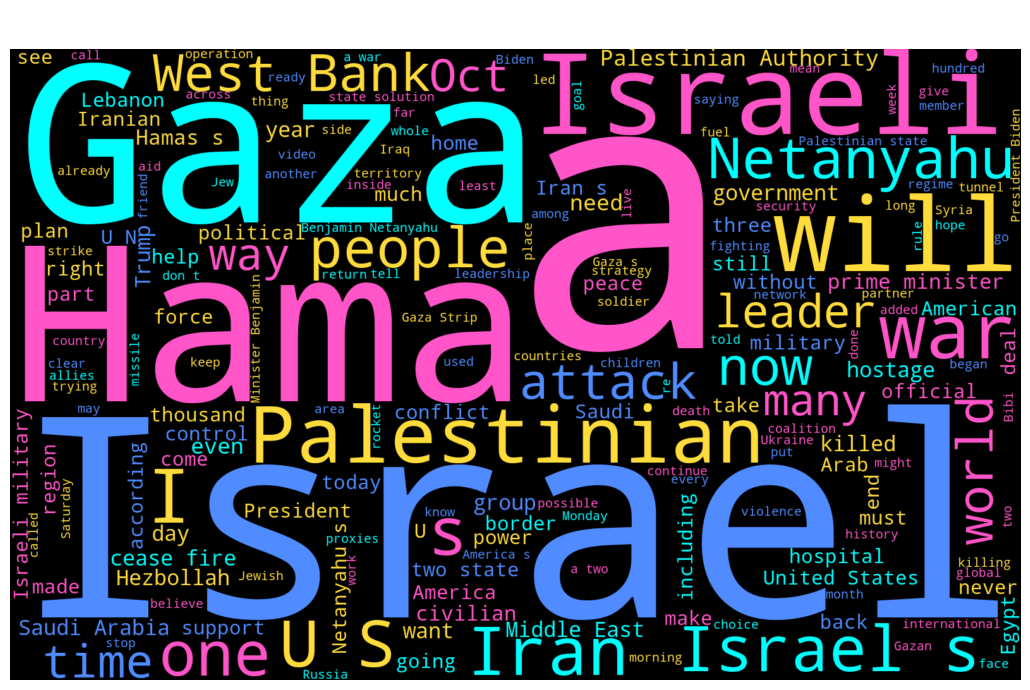

In [323]:
## Build corpus and text and plot and save
# Build corpus text and plot/save
corpus_text = " ".join(NewData3_df[TEXT_COL].fillna("").astype(str).tolist())
make_wordcloud(
    corpus_text,
    title="Corpus Word Cloud",
    save_path=f"{WC_DIR}/corpus_wordcloud.png"
)

In [324]:
## Svae wordcloud
print(f"Saved: {WC_DIR}/corpus_wordcloud.png")

Saved: ./exports/wordclouds/corpus_wordcloud.png


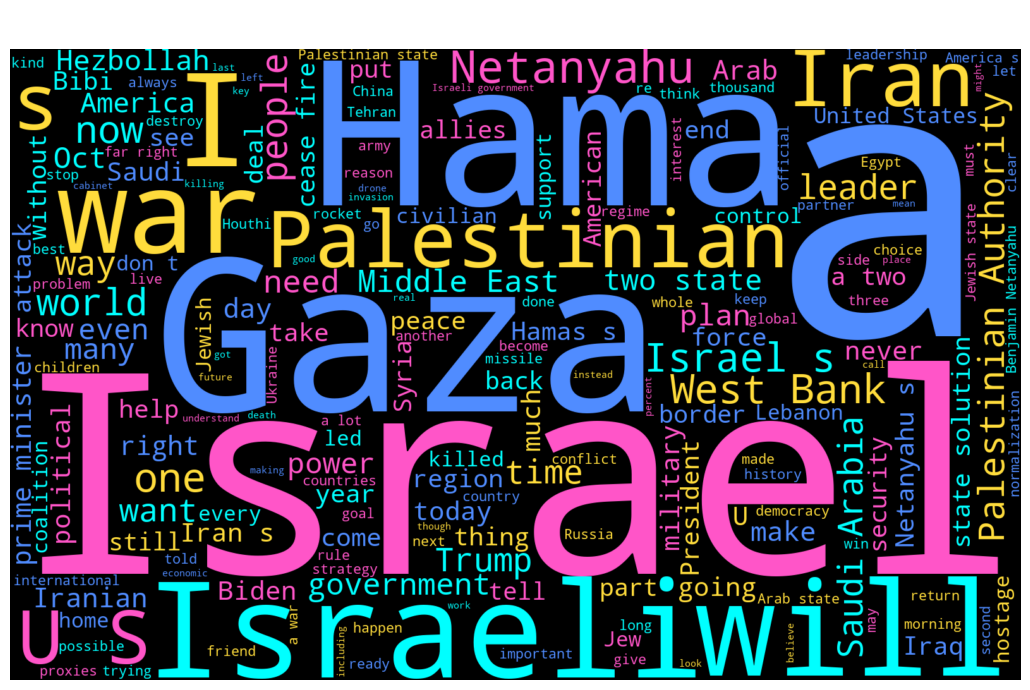

In [325]:
tf_text = " ".join(
    NewData3_df.loc[NewData3_df["Author"] == "Thomas Friedman", "text_combined_weighted"]
    .fillna("").astype(str)
)
make_wordcloud(tf_text, title="Thomas Friedman — Dark Mode", save_path="./exports/wordclouds/friedman_dark.png")

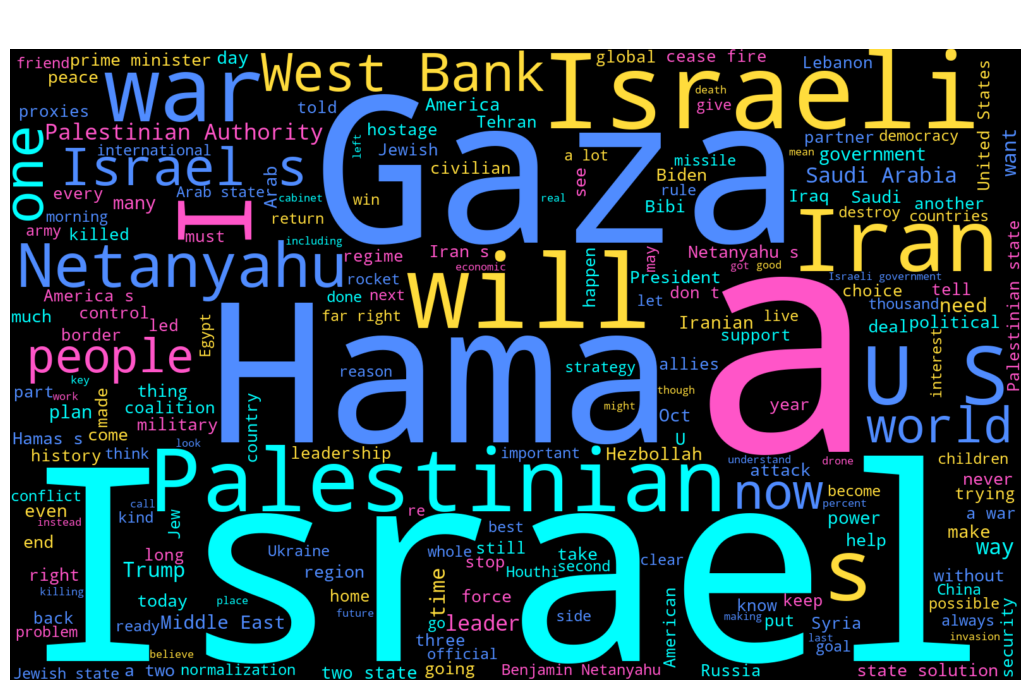

In [326]:
## By Author
# --- Word Cloud: Per Author (Thomas Friedman) ---
AUTHOR_COL = "Author"
target_author = "Thomas Friedman"

author_text = " ".join(
    NewData3_df.loc[NewData3_df[AUTHOR_COL] == target_author, TEXT_COL]
    .fillna("").astype(str).tolist()
)

safe_author = "".join(c for c in target_author if c.isalnum() or c in (" ","_","-")).strip().replace(" ","_")
make_wordcloud(
    author_text,
    title=f"Word Cloud — {target_author}",
    save_path=f"{WC_DIR}/wordcloud_{safe_author}.png"
)

In [327]:
print(f"Saved: {WC_DIR}/wordcloud_{safe_author}.png")

Saved: ./exports/wordclouds/wordcloud_Thomas_Friedman.png
